---

# ANALYSIS OF *CRX* DMS TRANSCRIPTIONAL REPORTER ASSAY

---

# Imports and Setup

In [1]:
import os
import fphd

if "SLURM_CPUS_PER_TASK" in os.environ:
    print("SLURM job setting: {} thread(s) available".format(os.environ["SLURM_CPUS_PER_TASK"]))
    os.environ["POLARS_MAX_THREADS"] = os.environ["SLURM_CPUS_PER_TASK"]
    fphd.set_available_threads(int(os.environ["SLURM_CPUS_PER_TASK"]))

SLURM job setting: 8 thread(s) available


In [2]:
from IPython.display import display, Markdown, HTML
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("jpeg")

import matplotlib
import matplotlib.pyplot as pyplot
import seaborn

import bokeh
import bokeh.plotting as bplot
bokeh.io.output_notebook()
import colorcet

from Bio.Seq import Seq
from Bio import AlignIO

import numpy
import polars
import pandas
import scipy
import statsmodels.api as statsmods
import statsmodels.formula.api as smfapi
from statsmodels.stats import multitest as smtest

polars.enable_string_cache()

Loading BokehJS ...

In [3]:
"""
Style Matplotlib plots
"""

plot_style = {
    "font.size": 12,
    "font.family": "sans-serif",
    "font.sans-serif": ["Inter"],
    "figure.figsize": [2, 2],
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.facecolor": (1, 1, 1, 0),
    "text.usetex": False,
    "lines.markersize": 3,
    "axes.titleweight": 600,
    "axes.labelweight": 600,
    "axes.labelsize": 9,
    "axes.facecolor": "none",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.5,
    "grid.color": "#303030",
    "grid.alpha": 0.1,
    "xtick.labelsize": 9,
    "xtick.major.width": 1.5,
    "xtick.minor.width": 1,
    "xtick.minor.visible": False,
    "ytick.labelsize": 9,
    "ytick.major.width": 1.5,
    "ytick.minor.width": 1,
    "ytick.minor.visible": False,
    "figure.frameon": False,
    "legend.frameon": False,
    "legend.fancybox": False,
    "legend.fontsize": 9,
    "legend.scatterpoints": 1,
    "legend.markerscale": 1,
    "legend.handlelength": 1.0,
    "legend.handletextpad": 0.2,
    "axes.prop_cycle": matplotlib.cycler(color=["k", "b", "g", "r", "c", "y"]),
}

pyplot.style.use(plot_style)
_ = pyplot.ioff()

cm_light_to_gray = matplotlib.colors.LinearSegmentedColormap.from_list("light_to_gray", ["#e0e0e0", "#404040"])
cm_light_to_blue = matplotlib.colors.LinearSegmentedColormap.from_list("light_to_blue", ["#e0e0ff", "#0000ff"])

In [4]:
bplot_style = {
    "attrs": {
        "figure": {
            "background_fill_color": None,
            "outline_line_color": None,
            "border_fill_color": None,
        },
        "Title": {
            "text_font": "Arial",
        },
        "Grid": {
            "grid_line_color": None
        },
        "Axis": {
            "major_label_text_font": "Arial",
            "major_label_text_font_size": "8pt",
            "major_label_text_color": "#000000",
            "axis_label_text_font": "Arial",
            "axis_label_text_font_size": "12pt",
            "axis_label_text_font_style": "bold",
            "axis_label_text_color": "#000000",
            "axis_line_width": 2,
            "axis_line_cap": "butt",
            "major_tick_line_width": 2,
            "major_tick_out": 10,
            "major_tick_in": 0,
            "major_tick_line_cap": "square",
            "minor_tick_line_width": 2,
            "minor_tick_out": 5,
            "minor_tick_line_cap": "square",
        },
        "ColorBar": {
            "title_text_font": "Arial",
            "title_text_font_size": "10pt",
            "title_text_font_style": "normal",
            "title_text_color": "#000000",
            "major_label_text_font": "Arial",
            "major_label_text_font_size": "8pt",
            "major_label_text_color": "#000000",
        },
        "Legend": {
            "label_text_font": "Arial",
            "label_text_font_size": "8pt",
            "background_fill_color": None,
            "border_line_color": None
        }
    }
}

bokeh.io.curdoc().theme = bokeh.themes.Theme(json=bplot_style)

In [5]:
"""
Common plotting functions
"""

# Adapted from https://stackoverflow.com/a/53865762

def calc_weights_for_scatter(x, y, bins=20):
    if type(x) is not numpy.ndarray or type(y) is not numpy.ndarray:
        raise ValueError("x and y must be `numpy.ndarray`s")
    
    bin_weights, xbins, ybins = numpy.histogram2d(x, y, bins=bins, density=False)
    weights = scipy.interpolate.interpn(points=(0.5*(xbins[1:] + xbins[:-1]), 0.5*(ybins[1:] + ybins[:-1])), values=bin_weights, xi=numpy.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    weights[numpy.where(numpy.isnan(weights))] = 0.0
    
    normalizer = matplotlib.colors.Normalize(vmin=numpy.min(weights), vmax=numpy.max(weights))
    
    return weights, normalizer

def reorder_points_and_weights(x, y, w, f = None):
    if type(x) is not numpy.ndarray or type(y) is not numpy.ndarray or type(w) is not numpy.ndarray:
        raise ValueError("x, y, and w must be `numpy.ndarray`s")
    
    x_, y_, w_ = x, y, w
    if f is not None:
        x_, y_, w_ = f(x), f(y), f(w)
    order = numpy.argsort(w_)
    return {
        "x": x_[order],
        "y": y_[order],
        "c": w_[order]
    }

def color_for_value(value, norm, cmap):
    return matplotlib.colors.rgb2hex(cmap(norm(value)))

def make_heatmap_figure(heatmap_data, heatmap_value_col, cmap, norm, wt_value, plot_average=True):
    
    heatmap_data_2d = polars.DataFrame(schema=["var_alt"], data=AAs).join(
            polars.DataFrame(schema=["var_pos"], data=list(range(1, 300))).join(
                heatmap_data, how="left", on="var_pos"
            ).pivot(index="var_alt", columns="var_pos", values=heatmap_value_col),
        how="left", on="var_alt"
    ).select(list(map(str, range(1,300)))).to_numpy()
    
    figure, axis = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(14, 3.8))
    
    axis.imshow(heatmap_data_2d, cmap=cmap, norm=norm, aspect="auto", interpolation="none", origin="lower", extent=(0.5, len(CRX_WT_AA)+0.5, -0.5, len(AAs)-0.5))

    wt_heatmap_data = polars.DataFrame(schema=["residue"], data=AAs).join(
        CRX_WT_AA_table.with_columns([
            polars.lit(wt_value).alias("value")
        ]).pivot(values="value", index="residue", columns="position"),
        how="left", on="residue"
    ).select(list(map(str, range(1,300)))).to_numpy()
    axis.imshow(wt_heatmap_data, cmap=cmap, norm=norm, aspect="auto", interpolation="none", origin="lower", extent=(0.5, len(CRX_WT_AA)+0.5, -0.5, len(AAs)-0.5))
    
    wt_positions = CRX_WT_AA_table.with_columns([
        polars.col("residue").replace(dict(zip(AAs, range(len(AAs)))), default=None).alias("ypos")
    ])
    axis.scatter(wt_positions["position"], wt_positions["ypos"], s=3, marker="o", color="#00000080", edgecolors="none")

    tick_positions = list(range(len(AAs)))
    tick_labels = AAs.copy()
    
    offset = 0
    if plot_average:
        offset = 2
        
        measurements_per_col = numpy.count_nonzero(~numpy.isnan(heatmap_data_2d), axis=0)
        cols_to_exclude = measurements_per_col < 5

        with numpy.errstate(divide="ignore", invalid="ignore"):
            raw_averages = numpy.sum(numpy.nan_to_num(heatmap_data_2d, nan=0), axis=0)/measurements_per_col
        masked_averages = numpy.ma.masked_array(data=raw_averages, mask=cols_to_exclude)
        average_heatmap_data = numpy.reshape(masked_averages.filled(numpy.nan), (1, -1))
        
        axis.imshow(average_heatmap_data, cmap=cmap, norm=norm, aspect="auto", interpolation="none", origin="lower", extent=(0.5, len(CRX_WT_AA)+0.5, -2, -1))

        tick_positions.append(-1.5)
        tick_labels.append("Average")
    
    disorder_plot_data = crx_predicted_disorder.with_columns([
        ((polars.col("predicted_disorder") * 3) - (4 + offset)).alias("transformed_disorder")
    ])
    axis.add_patch(matplotlib.patches.Rectangle((0.5, -(4 + offset)), len(CRX_WT_AA), 3, facecolor="#f0f0f0", edgecolor=None))
    axis.plot(disorder_plot_data["position"], disorder_plot_data["transformed_disorder"], linewidth=1, linestyle="-", color="#000000")
    tick_positions.append(-(2.5 + offset))
    tick_labels.append("Disorder")

    conservation_plot_data = crx_conservation.with_columns([
        ((polars.col("conservation") * 3) - (8 + offset)).alias("transformed_conservation")
    ])
    axis.add_patch(matplotlib.patches.Rectangle((0.5, -(8 + offset)), len(CRX_WT_AA), 3, facecolor="#f0f0f0", edgecolor=None))
    axis.plot(conservation_plot_data["position"], conservation_plot_data["transformed_conservation"], linewidth=1, linestyle="-", color="#000000")
    tick_positions.append(-(6.5 + offset))
    tick_labels.append("Conservation")

    axis.add_patch(matplotlib.patches.Rectangle((0.5, -(11 + offset)), len(CRX_WT_AA), 2, facecolor="#b3b3b3", edgecolor=None))
    for region in crx_regions.iter_rows(named=True):
        axis.add_patch(matplotlib.patches.Rectangle((region["start"] + 0.5, -(11 + offset)), region["stop"] - region["start"], 2, facecolor=region["color"], edgecolor="#d0d0d0" if region["precedence"] > 0 else "#000000", linewidth=1))
    axis.add_patch(matplotlib.patches.Rectangle((0.5, -(11 + offset)), len(CRX_WT_AA), 2, facecolor="#00000000", edgecolor="#000000", linewidth=1))
    tick_positions.append(-(10 + offset))
    tick_labels.append("Domains")

    axis.set_xticks([1, 50, 100, 150, 200, 250, 299])
    axis.set_yticks(tick_positions, labels=tick_labels, fontsize=6)
    axis.set(xlim=(-1, len(CRX_WT_AA) + 1), ylim=(-14, len(AAs) + 0.5), xlabel="CRX Position")

    axis.spines["left"].set_visible(False)
    axis.tick_params(axis="y", which="both", length=0)

    colorbar_axis = figure.add_axes([0.905, 0.28, 0.006, 0.5])
    colorbar = figure.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=colorbar_axis, orientation="vertical", drawedges=False)
    colorbar.ax.tick_params(labelsize=8)
    colorbar.outline.set_linewidth(0)
    colorbar.ax.minorticks_off()

    return figure, axis, colorbar

# Load Source Data

In [6]:
"""
Load CRX regions, disorder predictions, ClinVar variants, and the barcode:variant map
"""

crx_regions = polars.read_csv("external_data_sources/crx_regions.tsv", separator="\t")
crx_predicted_disorder = polars.read_csv("external_data_sources/CRX_predicted_disorder.tsv", separator="\t")
clinvar_variant_classifications = polars.read_csv("external_data_sources/CRX_clinvar_variants.tsv", separator="\t")
barcode_variant_map = polars.read_csv("external_data_sources/barcode_to_variant_map.tsv", separator="\t").drop("read_count")

In [7]:
"""
Load counts for input plasmid library
"""

plasmid_counts = polars.read_parquet("barcodes/plasmid_library.extracted_barcodes.counts.parquet").filter(
    polars.col("var_pos").is_null().not_()
).group_by(["var_ref", "var_pos", "var_alt"]).agg([
    polars.col("BC1").unique().count().cast(polars.UInt64).alias("BC1_count"),
    polars.col("BC2_count").sum(),
    polars.col("read_count").sum()
]).sort(["var_pos", "var_alt"])

In [8]:
CRX_WT_DNA = "ATGATGGCGTATATGAACCCGGGGCCCCACTATTCTGTCAACGCCTTGGCCCTAAGTGGCCCCAGTGTGGATCTGATGCACCAGGCTGTGCCCTACCCAAGCGCCCCCAGGAAGCAGCGGCGGGAGCGCACCACCTTCACCCGGAGCCAACTGGAGGAGCTGGAGGCACTGTTTGCCAAGACCCAGTACCCAGACGTCTATGCCCGTGAGGAGGTGGCTCTGAAGATCAATCTGCCTGAGTCCAGGGTTCAGGTTTGGTTCAAGAACCGGAGGGCTAAATGCAGGCAGCAGCGACAGCAGCAGAAACAGCAGCAGCAGCCCCCAGGGGGCCAGGCCAAGGCCCGGCCTGCCAAGAGGAAGGCGGGCACGTCCCCAAGACCCTCCACAGATGTGTGTCCAGACCCTCTGGGCATCTCAGATTCCTACAGTCCCCCTCTGCCCGGCCCCTCAGGCTCCCCAACCACGGCAGTGGCCACTGTGTCCATCTGGAGCCCAGCCTCAGAGTCCCCTTTGCCTGAGGCGCAGCGGGCTGGGCTGGTGGCCTCAGGGCCGTCTCTGACCTCCGCCCCCTATGCCATGACCTACGCCCCGGCCTCCGCTTTCTGCTCTTCCCCCTCCGCCTATGGGTCTCCGAGCTCCTATTTCAGCGGCCTAGACCCCTACCTTTCTCCCATGGTGCCCCAGCTAGGGGGCCCGGCTCTTAGCCCCCTCTCTGGCCCCTCCGTGGGACCTTCCCTGGCCCAGTCCCCCACCTCCCTATCAGGCCAGAGCTATGGCGCCTACAGCCCCGTGGATAGCTTGGAATTCAAGGACCCCACGGGCACCTGGAAATTCACCTACAATCCCATGGACCCTCTGGACTACAAGGATCAGAGTGCCTGGAAGTTTCAGATCTTG"
CRX_WT_AA = Seq(CRX_WT_DNA).translate()
AAs = ["R", "H", "K", "D", "E", "S", "T", "N", "Q", "C", "G", "P", "A", "V", "I", "L", "M", "F", "Y", "W"]

CRX_WT_AA_table = polars.DataFrame(map(lambda t: (t[0]+1, t[1]), enumerate(CRX_WT_AA)), ["position", "residue"])

In [9]:
"""
Generate CRX Conservation from MSA
"""

crx_msa = AlignIO.read("external_data_sources/2023.11.07.uniprotkb_uniref_cluster_50_UniRef50_O4.clustal", "clustal")

raw_conservation = []
raw_ungapped_conservation = []
for i, hs_crx_aa in enumerate(crx_msa[0].seq):
    if hs_crx_aa != "-":
        other_alignments = crx_msa[:,i][1:]
        match_count = 0
        total_ungapped_alignments = 0
        for other_crx_aa in other_alignments:
            if other_crx_aa == hs_crx_aa:
                match_count += 1
            if other_crx_aa != "-":
                total_ungapped_alignments += 1

        raw_conservation.append(match_count/len(other_alignments))
        raw_ungapped_conservation.append(match_count/total_ungapped_alignments)

crx_conservation = polars.DataFrame(data={
    "position": list(range(1, len(raw_conservation) + 1)),
    "conservation": raw_conservation,
    "conservation_ignoring_gaps": raw_ungapped_conservation
})
display(crx_conservation)

position,conservation,conservation_ignoring_gaps
i64,f64,f64
1,0.743017,0.977941
2,0.743017,0.977941
3,0.731844,0.963235
4,0.743017,0.977941
5,0.743017,0.992537
…,…,…
295,0.776536,0.978873
296,0.776536,0.978873
297,0.748603,0.985294


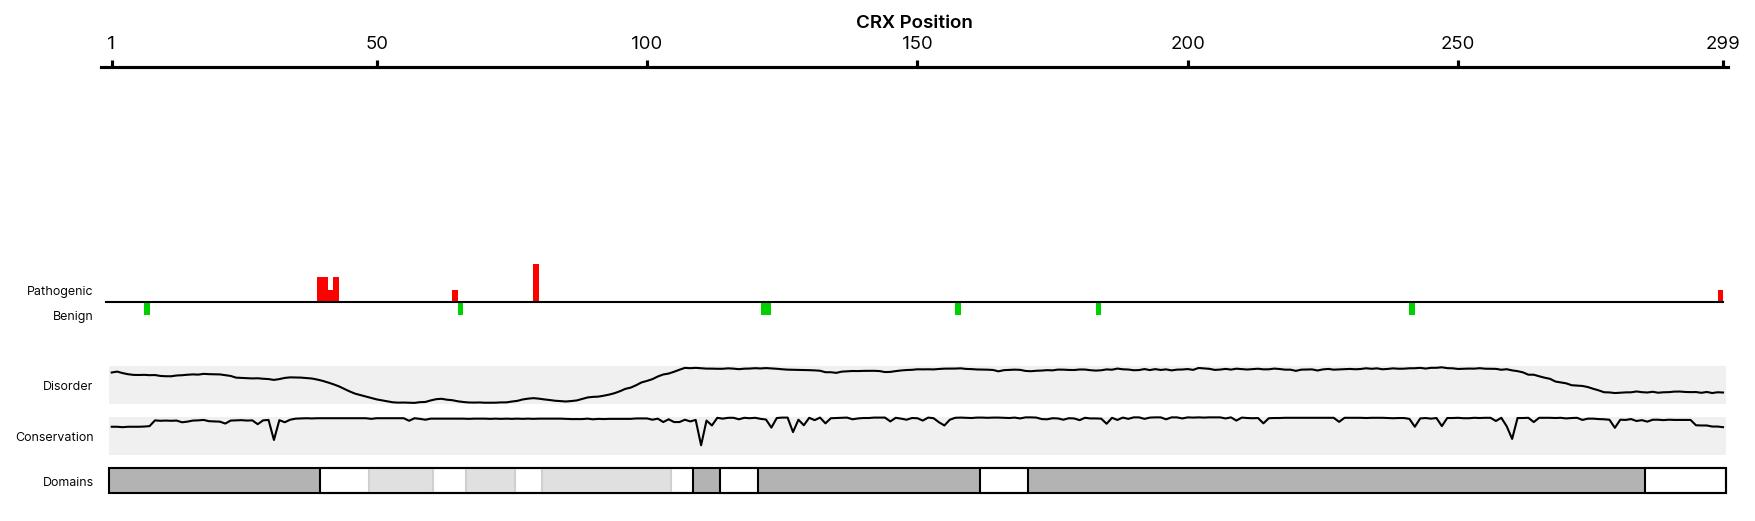

In [10]:
figure, axis = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(14, 3.8))

tick_positions = []
tick_labels = []

offset = 2

benign_var_position_data = clinvar_variant_classifications.filter(polars.col("simplified_clinical_significance") == "Benign").group_by(["var_pos"]).agg(polars.len().alias("count")).with_columns([
    polars.col("var_pos") - 1,
    -polars.col("count").cast(polars.Int64)
])

path_var_position_data = clinvar_variant_classifications.filter(polars.col("simplified_clinical_significance") == "Pathogenic").group_by(["var_pos"]).agg(polars.len().alias("count")).with_columns([
    polars.col("var_pos") - 1
])

axis.plot([0, 299], [2, 2], linewidth=1, linestyle="-", color="#000000")

axis.bar(x=benign_var_position_data["var_pos"], height=benign_var_position_data["count"], width=1, bottom=2, align="edge", color="#00d000")
tick_positions.append(1)
tick_labels.append("Benign")

axis.bar(x=path_var_position_data["var_pos"], height=path_var_position_data["count"], width=1, bottom=2, align="edge", color="#ff0000")
tick_positions.append(3)
tick_labels.append("Pathogenic")

disorder_plot_data = crx_predicted_disorder.with_columns([
    ((polars.col("predicted_disorder") * 3) - (4 + offset)).alias("transformed_disorder")
])
axis.add_patch(matplotlib.patches.Rectangle((0.5, -(4 + offset)), len(CRX_WT_AA), 3, facecolor="#f0f0f0", edgecolor=None))
axis.plot(disorder_plot_data["position"], disorder_plot_data["transformed_disorder"], linewidth=1, linestyle="-", color="#000000")
tick_positions.append(-(2.5 + offset))
tick_labels.append("Disorder")

conservation_plot_data = crx_conservation.with_columns([
    ((polars.col("conservation") * 3) - (8 + offset)).alias("transformed_conservation")
])
axis.add_patch(matplotlib.patches.Rectangle((0.5, -(8 + offset)), len(CRX_WT_AA), 3, facecolor="#f0f0f0", edgecolor=None))
axis.plot(conservation_plot_data["position"], conservation_plot_data["transformed_conservation"], linewidth=1, linestyle="-", color="#000000")
tick_positions.append(-(6.5 + offset))
tick_labels.append("Conservation")

axis.add_patch(matplotlib.patches.Rectangle((0.5, -(11 + offset)), len(CRX_WT_AA), 2, facecolor="#b3b3b3", edgecolor=None))
for region in crx_regions.iter_rows(named=True):
    axis.add_patch(matplotlib.patches.Rectangle((region["start"] + 0.5, -(11 + offset)), region["stop"] - region["start"], 2, facecolor=region["color"], edgecolor="#d0d0d0" if region["precedence"] > 0 else "#000000", linewidth=1))
axis.add_patch(matplotlib.patches.Rectangle((0.5, -(11 + offset)), len(CRX_WT_AA), 2, facecolor="#00000000", edgecolor="#000000", linewidth=1))
tick_positions.append(-(10 + offset))
tick_labels.append("Domains")

axis.set_xticks([1, 50, 100, 150, 200, 250, 299])
axis.set_yticks(tick_positions, labels=tick_labels, fontsize=6)
axis.set(xlim=(-1, len(CRX_WT_AA) + 1), ylim=(-14, len(AAs) + 0.5), xlabel="CRX Position")

axis.spines["left"].set_visible(False)
axis.tick_params(axis="y", which="both", length=0)

axis.xaxis.tick_top()
axis.xaxis.set_label_position("top")
axis.spines["top"].set_visible(True)
axis.spines["bottom"].set_visible(False)

display(figure)
figure.savefig(f"output/clinvar_variants_overview.svg", bbox_inches="tight")
pyplot.close(figure)

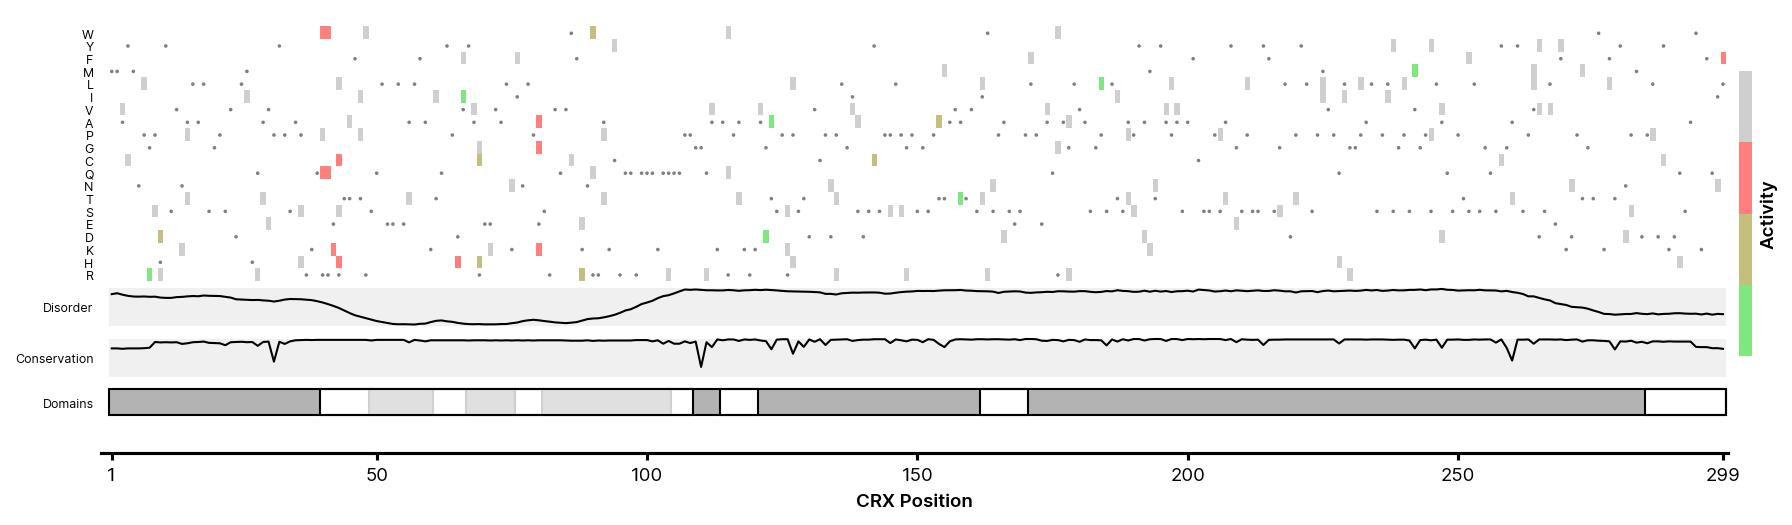

In [11]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("pathlevel", ["#00d00080", "#8b800080", "#ff000080", "#a0a0a080"], N=4)
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

heatmap_data = clinvar_variant_classifications.with_columns([
    polars.col("simplified_clinical_significance").replace({
        "Benign": 0,
        "Conflicting": 1,
        "Pathogenic": 2,
        "VUS": 3
    }, default=None).alias("numeric_simplified_clinical_significance")
])

figure, axis, colorbar = make_heatmap_figure(heatmap_data, "numeric_simplified_clinical_significance", cmap, norm, numpy.nan, plot_average=False)

colorbar.set_label("Activity")
colorbar.ax.set_yticks([])

figure.savefig(f"output/clinvar_variants_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

# Process Reads and Calculate Activity Scores

In [12]:
"""
Load sample information and barcode counts for each sample
"""

samples_information = polars.read_csv("sample_info.tsv", separator="\t").with_columns([
    ("CTRA-" + polars.col("replicate").cast(str) + polars.col("bin")).alias("sample_name")
]).drop(["read1_file", "read2_file"])

combined_counts = None

for sample in tqdm(samples_information.rows(named=True)):
    raw_barcodes = polars.read_parquet(f"""barcodes/{sample['sample_name']}.extracted_barcodes.counts.parquet""")
    
    counts = raw_barcodes.with_columns([
        polars.lit(sample["replicate"]).cast(polars.UInt64).alias("replicate"),
        polars.lit(sample["bin"]).alias("bin"),
        polars.col("read_count").sum().alias("total_num_reads")
    ])
    
    if combined_counts is None:
        combined_counts = counts
    else:
        combined_counts.vstack(counts, in_place=True)

samples_counts = combined_counts.rechunk()

display(Markdown(f"### Counts"))

display(samples_counts)

  0%|          | 0/16 [00:00<?, ?it/s]

### Counts

BC1,BC2,read_count,corrected_BC1_distance,uncorrected_BC1,var_ref,var_pos,var_alt,replicate,bin,total_num_reads
str,str,u64,u64,str,str,i64,str,u64,str,u64
"""GGCGGTGTCCAATG…","""TCAGTAAGTGTATG…",20327,null,null,"""D""",219,"""F""",1,"""A""",63216426
"""TTTATCGCACATTT…","""GGCCATTGTGGCGT…",19072,null,null,"""N""",89,"""L""",1,"""A""",63216426
"""GTGTCCTGGCATAT…","""AAATTTTGTGTGCC…",18494,null,null,"""H""",27,"""R""",1,"""A""",63216426
"""TATCATTCCCACGG…","""CGTTCCCTTGAAGG…",18483,null,null,"""R""",43,"""F""",1,"""A""",63216426
"""ACCGTGGCACATAG…","""TGCGCTGGTGCGTG…",18437,null,null,"""N""",89,"""V""",1,"""A""",63216426
…,…,…,…,…,…,…,…,…,…,…
"""TTTGTGTCCCAGGA…","""GTGTGTTGTGTTGT…",1,null,null,"""Q""",100,"""Y""",4,"""D""",64337353
"""GGCTGGTTCCACCA…","""TGGTGCCGTGCTGA…",1,null,null,"""Q""",39,"""G""",4,"""D""",64337353
"""CGGAGGACTCACAA…","""TAAGCGCCTGCAAA…",1,1,"""AGGAGGACTCACAA…","""A""",233,"""C""",4,"""D""",64337353


In [13]:
"""
Filter only to BC1-BC2 pairs with at least 3 reads
"""

samples_counts = samples_counts.filter(polars.col("read_count") >= 3)

display(samples_counts)

BC1,BC2,read_count,corrected_BC1_distance,uncorrected_BC1,var_ref,var_pos,var_alt,replicate,bin,total_num_reads
str,str,u64,u64,str,str,i64,str,u64,str,u64
"""GGCGGTGTCCAATG…","""TCAGTAAGTGTATG…",20327,null,null,"""D""",219,"""F""",1,"""A""",63216426
"""TTTATCGCACATTT…","""GGCCATTGTGGCGT…",19072,null,null,"""N""",89,"""L""",1,"""A""",63216426
"""GTGTCCTGGCATAT…","""AAATTTTGTGTGCC…",18494,null,null,"""H""",27,"""R""",1,"""A""",63216426
"""TATCATTCCCACGG…","""CGTTCCCTTGAAGG…",18483,null,null,"""R""",43,"""F""",1,"""A""",63216426
"""ACCGTGGCACATAG…","""TGCGCTGGTGCGTG…",18437,null,null,"""N""",89,"""V""",1,"""A""",63216426
…,…,…,…,…,…,…,…,…,…,…
"""ATAATCTCGCATTC…","""GGGTGCAGTGTTAA…",3,1,"""ATAATCTCGCATTA…","""P""",135,"""S""",4,"""D""",64337353
"""TGTTTGTTTCATAT…","""TAGCGCCATGTGTG…",3,null,null,"""M""",1,"""M""",4,"""D""",64337353
"""CTAAATCAGCAGAT…","""AATGGATTTGCATT…",3,null,null,"""M""",5,"""H""",4,"""D""",64337353


In [14]:
"""
Generate a list of poorly-measured variants with few BC2s
"""

poorly_measured_variants = samples_counts.group_by(["replicate", "var_ref", "var_pos", "var_alt"]).agg([
    polars.col("BC2").unique().count().cast(polars.UInt64).alias("unique_BC2_count")
]).pivot(values="unique_BC2_count", index=["var_ref", "var_pos", "var_alt"], columns="replicate").sort(["var_pos", "var_alt"]).filter((polars.col("1") < 10) | (polars.col("2") < 10) | (polars.col("3") < 10) | (polars.col("4") < 10))

display(poorly_measured_variants)

var_ref,var_pos,var_alt,1,2,3,4
str,i64,str,u64,u64,u64,u64
"""M""",2,"""V""",13,18,9,19
"""N""",6,"""F""",9,19,14,15
"""P""",9,"""Y""",9,38,36,30
"""A""",17,"""H""",22,7,21,16
"""S""",19,"""M""",38,18,20,6
…,…,…,…,…,…,…
"""S""",292,"""R""",21,19,32,6
"""K""",295,"""I""",27,25,9,19
"""L""",299,"""N""",10,11,7,13


In [15]:
raw_bin_mean_fluorescence = [ # Computed from flow cytometry bin average fluorescence
    (1, "A", 37.07),
    (1, "B", 179.85),
    (1, "C", 624.75),
    (1, "D", 2836.04),
    (2, "A", 35.72),
    (2, "B", 179.40),
    (2, "C", 619.24),
    (2, "D", 2659.13),
    (3, "A", 31.46),
    (3, "B", 181.46),
    (3, "C", 623.93),
    (3, "D", 2723.14),
    (4, "A", 34.76),
    (4, "B", 180.59),
    (4, "C", 619.20),
    (4, "D", 2674.46),
]

bin_mean_fluorescence = polars.DataFrame(raw_bin_mean_fluorescence, schema={"replicate": polars.UInt64, "bin": polars.Utf8, "mean_bin_fluorescence": polars.Float64})
display(bin_mean_fluorescence)

replicate,bin,mean_bin_fluorescence
u64,str,f64
1,"""A""",37.07
1,"""B""",179.85
1,"""C""",624.75
1,"""D""",2836.04
2,"""A""",35.72
…,…,…
3,"""D""",2723.14
4,"""A""",34.76
4,"""B""",180.59


In [16]:
"""
Compute activity scores for each BC1
"""

barcode_activity_scores = samples_counts.group_by(["replicate", "bin", "var_ref", "var_pos", "var_alt", "BC1"]).agg([
    ((polars.col("read_count").cast(polars.UInt64).sum() * 1_000_000)/polars.col("total_num_reads").first()).alias("cpm"),
    polars.col("BC2").count().cast(polars.UInt64).alias("BC2_count")
]).pivot(values="cpm", index=["replicate", "var_pos", "var_ref", "var_alt", "BC1"], columns="bin").fill_null(0).with_columns([
    (polars.col("A") + polars.col("B") + polars.col("C") + polars.col("D")).alias("sum(ABCD)")
]).filter(
    ((polars.col("A") > 0.01) & (polars.col("B") > 0.01)) |
    ((polars.col("B") > 0.01) & (polars.col("C") > 0.01)) |
    ((polars.col("C") > 0.01) & (polars.col("D") > 0.01))
).join(
    bin_mean_fluorescence.with_columns([
        polars.concat_str([polars.col("bin"), polars.lit("_mean_fluorescence")]).alias("bin")
    ]).pivot(values="mean_bin_fluorescence", index="replicate", columns="bin"),
    how="left", on="replicate"
).with_columns([
    (polars.col("A")/polars.col("sum(ABCD)") * polars.col("A_mean_fluorescence") +
    polars.col("B")/polars.col("sum(ABCD)") * polars.col("B_mean_fluorescence") +
    polars.col("C")/polars.col("sum(ABCD)") * polars.col("C_mean_fluorescence") +
    polars.col("D")/polars.col("sum(ABCD)") * polars.col("D_mean_fluorescence")).alias("activity_score")
])

"""
Drop scores for variants that are underrepresented in the input plasmid library and any poorly-measured variants
"""

barcode_activity_scores = barcode_activity_scores.join(
    plasmid_counts.filter(polars.col("BC1_count") > 3).select(["var_ref", "var_pos", "var_alt"]),
    how="inner", on=["var_ref", "var_pos", "var_alt"]
).join(
    poorly_measured_variants.select(["var_ref", "var_pos", "var_alt"]),
    how="anti", on=["var_ref", "var_pos", "var_alt"]
)

"""
Average per-barcode activity scores to compute per-variant activity scores
"""

variant_activity_scores = barcode_activity_scores.group_by(["replicate", "var_ref", "var_pos", "var_alt"]).agg([
    polars.col("activity_score").mean(),
    polars.len().alias("measurement_count")
])

"""
Normalize activity scores to wildtype
"""

variant_activity_scores = variant_activity_scores.join(variant_activity_scores.filter((polars.col("var_ref") == "M") & (polars.col("var_pos") == 1) & (polars.col("var_alt") == "M")).select([
    polars.col("replicate"),
    polars.col("activity_score").alias("wt_activity_score")
]), how="left", on="replicate").with_columns([
    (polars.col("activity_score")/polars.col("wt_activity_score")).alias("normalized_activity_score")
]).drop("wt_activity_score")

variant_activity_scores = variant_activity_scores.sort(["var_pos", "var_alt", "replicate"])

"""
Compute mean variant activity scores, combining replicates
"""

mean_variant_activity_scores = variant_activity_scores.group_by(["var_ref", "var_pos", "var_alt"]).agg([
    polars.col("activity_score").mean().alias("activity_score_mean"),
    polars.col("activity_score").std().alias("activity_score_std"),
    polars.col("measurement_count").sum(),
    polars.col("normalized_activity_score").mean().alias("normalized_activity_score_mean"),
    polars.col("normalized_activity_score").std().alias("normalized_activity_score_std"),
])

display(mean_variant_activity_scores)

var_ref,var_pos,var_alt,activity_score_mean,activity_score_std,measurement_count,normalized_activity_score_mean,normalized_activity_score_std
str,i64,str,f64,f64,u32,f64,f64
"""M""",1,"""M""",859.839157,56.482163,12664,1.0,0.0
"""M""",2,"""D""",1565.513525,172.693927,29,1.832481,0.290824
"""M""",2,"""G""",929.557204,183.082587,34,1.075135,0.152257
"""M""",2,"""R""",925.65043,129.603899,33,1.079553,0.162236
"""M""",2,"""W""",631.263607,253.791415,17,0.734639,0.281695
…,…,…,…,…,…,…,…
"""Q""",297,"""V""",557.512212,94.995151,28,0.655348,0.150678
"""I""",298,"""S""",1590.169619,124.600055,37,1.85416,0.176194
"""I""",298,"""W""",1017.753191,163.871343,32,1.18339,0.171869


# Library Quality Metrics

## Per-Variant Activity Correlations

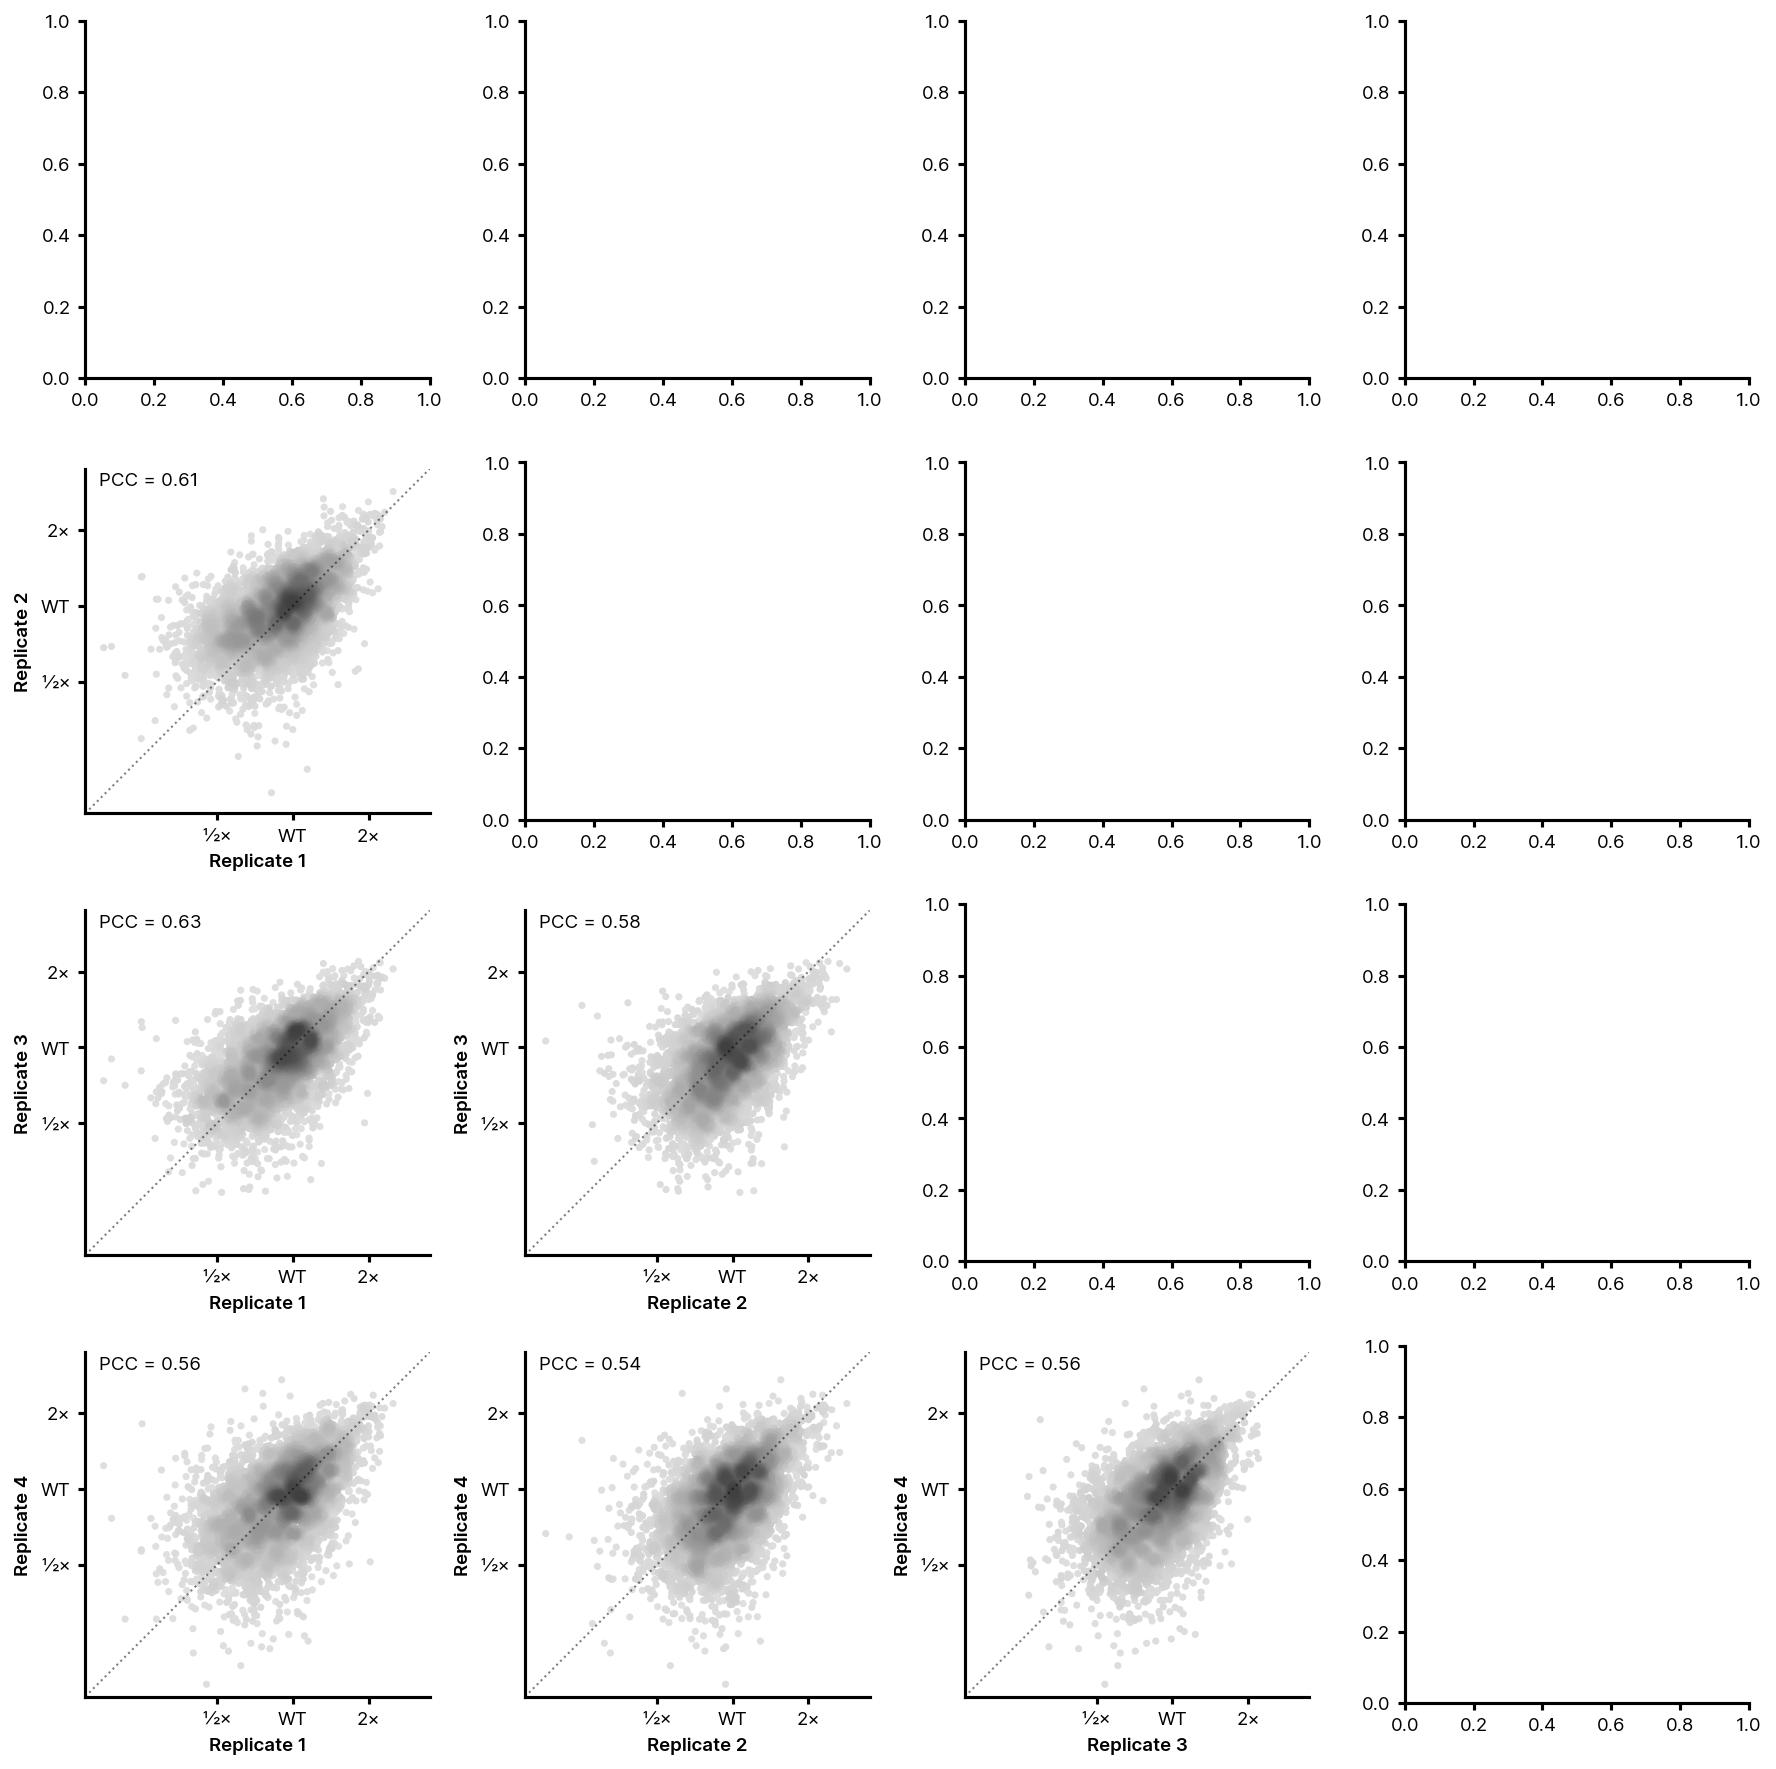

In [17]:
"""
Plot replicate-to-replicate reproducibility
"""

display(Markdown("## Per-Variant Activity Correlations"))

reproducibility = variant_activity_scores.filter(
    polars.col("var_ref") != polars.col("var_alt")
).pivot(
    values="normalized_activity_score",
    index=["var_pos", "var_ref", "var_alt"],
    columns="replicate"
).sort(["var_pos", "var_alt"]).fill_null(0)

reproducibility_measurements = variant_activity_scores.filter(
    polars.col("var_ref") != polars.col("var_alt")
).pivot(
    values="measurement_count",
    index=["var_pos", "var_ref", "var_alt"],
    columns="replicate"
).sort(["var_pos", "var_alt"]).fill_null(0)

replicates = ["1", "2", "3", "4"]

comparisons = []
for i in range(len(replicates)):
    for j in range(i+1, len(replicates)):
        comparisons.append((i, j, replicates[i], replicates[j]))

figure, axes = pyplot.subplots(nrows=len(replicates), ncols=len(replicates), sharex=False, sharey=False, figsize=(3*len(replicates), 3*len(replicates)))

for i, j, first, second in comparisons:

    axis = axes[j,i]
    
    bounds = (0.15, 3.5)
    bins = numpy.geomspace(start=bounds[0], stop=bounds[1], num=40)

    x = (reproducibility[first] + 0.01).to_numpy()
    y = (reproducibility[second] + 0.01).to_numpy()

    weights, color_normalizer = calc_weights_for_scatter(x, y, bins=bins)
    
    axis.scatter(**reorder_points_and_weights(x, y, weights), cmap=cm_light_to_gray, norm=color_normalizer, s=6, marker="o", rasterized=True)

    axis.text(0.17, 3, f"PCC = {scipy.stats.pearsonr(x, y).statistic:.2f}", fontsize=9, horizontalalignment="left")
    
    axis.plot((bounds[0], bounds[1]), (bounds[0], bounds[1]), color="#00000080", linestyle=":", linewidth=1, marker=None)
    
    axis.set(xlim=bounds, ylim=bounds, xlabel=f"Replicate {first}", ylabel=f"Replicate {second}")
    axis.set_xscale("log", base=10)
    axis.set_yscale("log", base=10)
    axis.set_xticks([0.5, 1, 2])
    axis.set_xticklabels(["½×", "WT", "2×"])
    axis.set_yticks([0.5, 1, 2])
    axis.set_yticklabels(["½×", "WT", "2×"]) 
    axis.minorticks_off()
    axis.set_aspect("equal")

figure.tight_layout()
figure.savefig(f"output/activity_correlations_per_variant.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

## Activity Score Correlations with Library Abundance

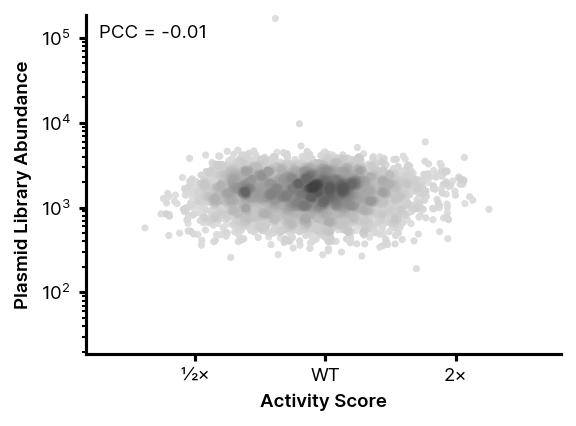

In [18]:
"""
Plot activity score concordance with plasmid library abundance
"""

display(Markdown("## Activity Score Correlations with Library Abundance"))

concordance = mean_variant_activity_scores.filter(polars.col("var_ref") != polars.col("var_alt")).join(plasmid_counts, how="left", on=["var_ref", "var_pos", "var_alt"])

figure, axis = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(4, 3))
x_bounds = (0.28, 3.5)
y_bounds = (concordance["read_count"].min() * 0.1, concordance["read_count"].max() * 1.1)
bins = numpy.geomspace(start=(x_bounds[0], y_bounds[0]), stop=(x_bounds[1], y_bounds[1]), axis=1, num=80)

x = concordance["normalized_activity_score_mean"].to_numpy()
y = concordance["read_count"].to_numpy()

weights, color_normalizer = calc_weights_for_scatter(x, y, bins=bins)
axis.scatter(**reorder_points_and_weights(x, y, weights), cmap=cm_light_to_gray, norm=color_normalizer, s=6, marker="o", rasterized=True)

axis.text(0.3, 1e5, f"PCC = {scipy.stats.pearsonr(x, y).statistic:.2f}", fontsize=9, horizontalalignment="left")

axis.set(xlim=x_bounds, ylim=y_bounds, xlabel="Activity Score", ylabel="Plasmid Library Abundance")
axis.set_xscale("log", base=10)
axis.set_yscale("log", base=10)

axis.set_xticks([0.5, 1, 2])
axis.set_xticklabels(["½×", "WT", "2×"])
axis.tick_params(axis="x", which="minor", bottom=False)

figure.tight_layout()
figure.savefig(f"output/activity_correlations_plasmid_library.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

# Visualizations

In [19]:
"""
Plot heatmap of activity scores
"""

data_source = bokeh.models.ColumnDataSource(mean_variant_activity_scores.to_pandas())
color_mapper = bokeh.models.LogColorMapper(palette=colorcet.coolwarm, low=0.33, high=3, nan_color="#000000")

display(Markdown(f"`normalized_activity_score_mean` ranges from {mean_variant_activity_scores['normalized_activity_score_mean'].min():0.3f} to {mean_variant_activity_scores['normalized_activity_score_mean'].max():0.3f}"))

plot = bokeh.plotting.figure(width=1400, height=320, title=f"Activity", x_axis_label="CRX Position", y_axis_label="Residue", tools=["hover", "save", "reset"], x_range=bokeh.models.Range1d(0, 300), y_range=AAs)
legend_items = []

var_renderer = plot.rect(x="var_pos", y="var_alt", width=1, height=1, source=data_source, line_color=None, fill_color=bokeh.transform.transform("normalized_activity_score_mean", color_mapper))

wt_data_source = bokeh.models.ColumnDataSource(CRX_WT_AA_table.to_pandas())
wt_renderer = plot.rect(x="position", y="residue", width=1, height=1, source=wt_data_source, line_color=None, fill_color=colorcet.coolwarm[len(colorcet.coolwarm)//2], hatch_color="#000000", hatch_pattern="v", hatch_weight=0.5, hatch_scale=4)
legend_items.append(("WT", [wt_renderer]))

"""
for i, (classification, classification_data) in enumerate(clinvar_variant_classifications.group_by("simplified_clinical_significance", maintain_order=True)):
    class_data_source = bokeh.models.ColumnDataSource(classification_data.to_pandas())
    class_renderer = plot.rect(x="var_pos", y="var_alt", width=1, height=1, source=class_data_source, line_color=colorcet.glasbey_dark[i], line_width=1, fill_color=None)
    class_renderer.visible = False
    legend_items.append((f"ClinVar {classification}", [class_renderer]))
    
gnomad_data_source = bokeh.models.ColumnDataSource(gnomad_variants.filter(polars.col("allele_count") > 10).to_pandas())
gnomad_renderer = plot.rect(x="var_pos", y="var_alt", width=1, height=1, source=gnomad_data_source, line_color="#000000", line_width=1, fill_color=None)
gnomad_renderer.visible = False
legend_items.append(("gnomAD Common Variants", [gnomad_renderer]))

interesting_data_source = bokeh.models.ColumnDataSource(interesting_variants.to_pandas())
interesting_renderer = plot.rect(x="var_pos", y="var_alt", width=1, height=1, source=interesting_data_source, line_color="#000000", line_width=1, fill_color=None)
interesting_renderer.visible = False
legend_items.append(("Selected Variants", [interesting_renderer]))
"""

plot.yaxis.major_label_text_font = "Menlo, monospace"
plot.yaxis.major_label_text_font_size = "6pt"

color_bar = bokeh.models.ColorBar(color_mapper=color_mapper, title="Activity", location=(0, 0), width=10, bar_line_color="#000000", major_tick_in=0, major_tick_out=0)
plot.add_layout(color_bar, 'right')
plot.hover.tooltips = [
    ("Variant", "@var_ref@var_pos@var_alt"),
    ("Activity (mean)", "@normalized_activity_score_mean"),
    ("Activity (std)", "@normalized_activity_score_std"),
    ("Measurement Count", "@measurement_count")
]
plot.hover.renderers = [var_renderer]

plot.xaxis.visible = False

legend = bokeh.models.Legend(items=legend_items, orientation="horizontal", nrows=2)
legend.click_policy = "hide"
plot.add_layout(legend, "above")

common_plot = bokeh.plotting.figure(width=1400, height=40, x_axis_label="CRX Position", tools=["save"], y_range=["Disorder", "Avg."])
common_plot.x_range = plot.x_range
common_plot.xaxis.visible = False
common_plot.toolbar_location = "right"
common_plot.toolbar.logo = None
common_plot.yaxis.major_label_text_font_size = "6pt"

avg_renderer = common_plot.rect(source=bokeh.models.ColumnDataSource(mean_variant_activity_scores.filter(polars.col("var_ref") != polars.col("var_alt")).group_by(["var_ref", "var_pos"]).agg([
    polars.col("normalized_activity_score_mean").mean().alias("normalized_activity_score_mean_for_position"),
    polars.lit("Avg.").alias("ypos")
]).to_pandas()), x="var_pos", y="ypos", width=1, height=1, fill_color=bokeh.transform.transform("normalized_activity_score_mean_for_position", color_mapper), fill_alpha=1, line_color=None)
common_plot.add_tools(bokeh.models.HoverTool(renderers=[avg_renderer], tooltips=[
    ("Position", "@var_ref@var_pos"),
    ("Mean Variant Activity", "@normalized_activity_score_mean_for_position"),
], visible=False))

disorder_color_mapper = bokeh.models.LinearColorMapper(palette=colorcet.CET_L18, low=0, high=1)
disorder_renderer = common_plot.rect(source=bokeh.models.ColumnDataSource(crx_predicted_disorder.with_columns([
    polars.lit("Disorder").alias("ypos")
]).to_pandas()), x="position", y="ypos", width=1, height=1, fill_color=bokeh.transform.transform("predicted_disorder", disorder_color_mapper), fill_alpha=1, line_color=None)
common_plot.add_tools(bokeh.models.HoverTool(renderers=[disorder_renderer], tooltips=[
    ("Position", "@position"),
    ("Disorder", "@predicted_disorder"),
], visible=False))

domains_plot = bokeh.plotting.figure(width=1400, height=75, x_axis_label="CRX Position", y_range=(0, crx_regions["precedence"].max()), tools=["hover", "save"])
domains_plot.x_range = plot.x_range
domains_plot.yaxis.visible = False
domains_plot.toolbar_location = "right"
domains_plot.quad(left=0, right=299, bottom=0, top=1, fill_color="#b3b3b3", fill_alpha=1, line_color="#000000")
domains_plot.quad(source=bokeh.models.ColumnDataSource(crx_regions.to_pandas()), bottom=0, top=1, left=bokeh.transform.dodge("start", -0.5), right=bokeh.transform.dodge("stop", 0.5), fill_color="color", fill_alpha=1, line_color="#000000")
domains_labels = bokeh.models.LabelSet(x="start", y=0, text="region", x_offset=2, y_offset=5, source=bokeh.models.ColumnDataSource(crx_regions.filter(polars.col("precedence") == 0).to_pandas()), text_font_size="6pt", text_font_style="bold")
domains_plot.add_layout(domains_labels)
domains_plot.hover.tooltips = [
    ("Region", "@region"),
    ("Bounds", "@start-@stop")
]
domains_plot.toolbar.logo = None
domains_plot.sizing_mode = "scale_width"

plot.sizing_mode = "scale_width"
common_plot.sizing_mode = "scale_width"
layout = bokeh.layouts.gridplot([[plot], [common_plot], [domains_plot]], merge_tools=False)
layout.sizing_mode = "scale_width"

display(Markdown("## Activity Heatmap (DMS)"))
#bokeh.plotting.save(layout, filename="output/dms_activity_map.html", title="CRX Variant Activity")
bokeh.io.show(layout)

`normalized_activity_score_mean` ranges from 0.384 to 2.386

## Activity Heatmap (DMS)

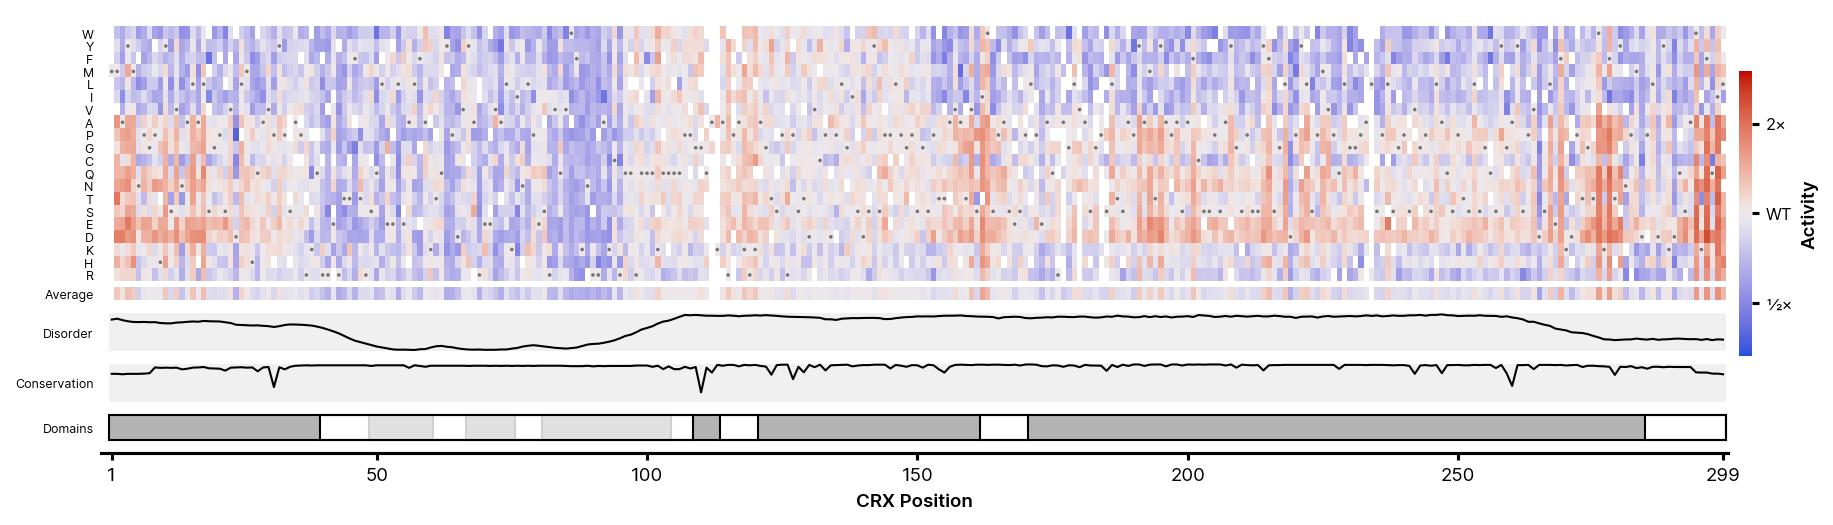

In [20]:
cmap = matplotlib.colormaps.get_cmap("cet_coolwarm")
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.LogNorm(vmin=0.33, vmax=3)

figure, axis, colorbar = make_heatmap_figure(mean_variant_activity_scores, "normalized_activity_score_mean", cmap, norm, 1.0, plot_average=True)

colorbar.set_label("Activity")
colorbar.ax.set_yticks([0.5, 1, 2]) 
colorbar.ax.set_yticklabels(["½×", "WT", "2×"]) 

figure.savefig(f"output/activity_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

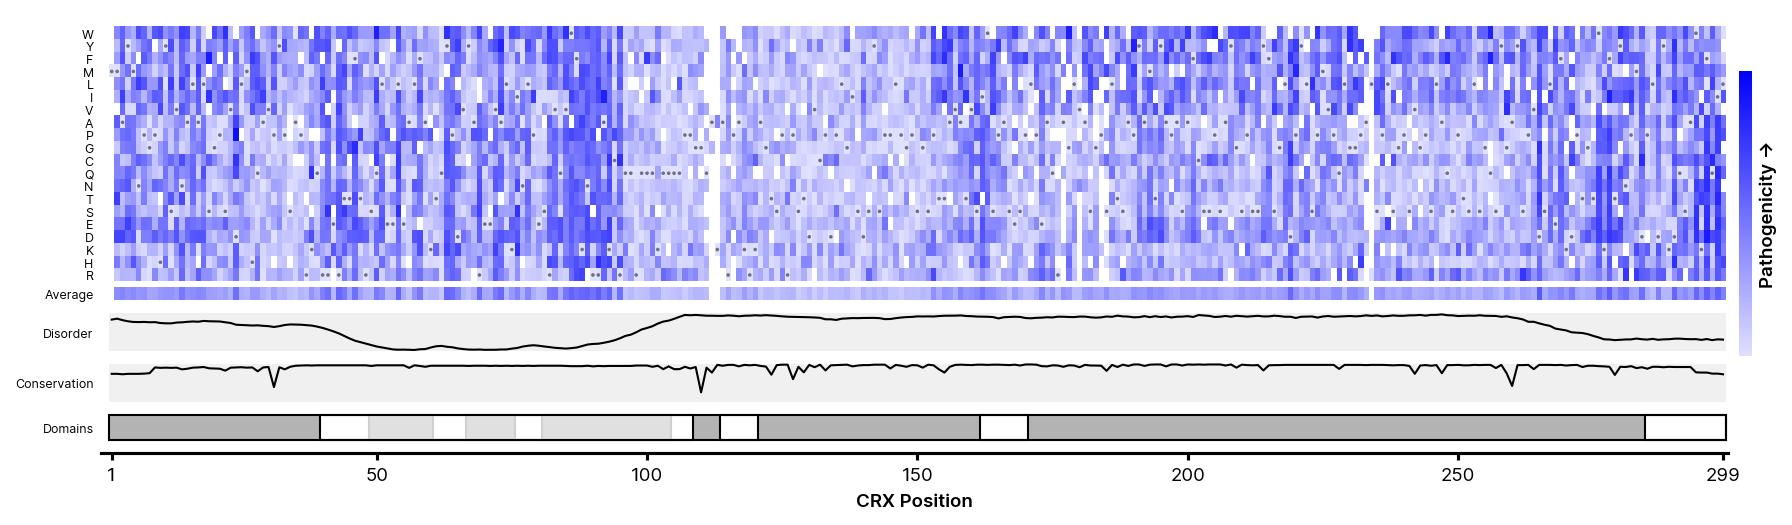

In [21]:
cmap = cm_light_to_blue
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.66)

heatmap_data = mean_variant_activity_scores.with_columns([
    polars.when(polars.col("normalized_activity_score_mean") < 1).then(polars.col("normalized_activity_score_mean")).otherwise(1/polars.col("normalized_activity_score_mean"))
]).with_columns([
    (1 - polars.col("normalized_activity_score_mean")).alias("normalized_activity_score_mean")
])

figure, axis, colorbar = make_heatmap_figure(heatmap_data, "normalized_activity_score_mean", cmap, norm, 0.0, plot_average=True)

colorbar.set_label("Pathogenicity →")
colorbar.ax.set_yticks([])

figure.savefig(f"output/DMS_pathogenicity_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

### Known Clinvar Variants (DMS)

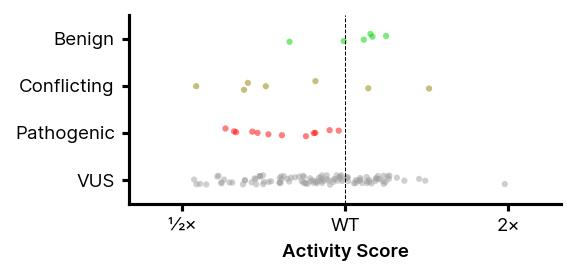

In [22]:
"""
Plot activity scores for known variants
"""

known_variant_data = mean_variant_activity_scores.join(clinvar_variant_classifications, how="left", on=["var_ref", "var_pos", "var_alt"]).filter(polars.col("simplified_clinical_significance").is_null().not_())

figure, axis = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(4, 2))

seaborn.stripplot(ax=axis, data=known_variant_data.to_pandas(), x="normalized_activity_score_mean", y="simplified_clinical_significance", hue="simplified_clinical_significance", legend=False, s=3, order=["Benign", "Conflicting", "Pathogenic", "VUS"], hue_order=["Benign", "Conflicting", "Pathogenic", "VUS"], palette=["#00d00080", "#8b800080", "#ff000080", "#a0a0a080"], rasterized=True)
axis.axvline(x=1, color="#000000", linewidth=0.5, linestyle="--", zorder=10)
axis.set(xlabel="Activity Score", ylabel=None, xlim=(0.4, 2.5))
axis.set_xscale("log", base=10)
axis.minorticks_off()
axis.set_xticks([0.5, 1, 2])
axis.set_xticklabels(["½×", "WT", "2×"]) 

figure.tight_layout()

figure.savefig(f"output/known_variant_activity_scores.svg", bbox_inches="tight", dpi=600)
display(Markdown("### Known Clinvar Variants (DMS)"))
display(figure)
pyplot.close(figure)

In [23]:
"""
Write ChimeraX script for coloring residues by activity score
"""

with open("output/chimerax_color_crx_residues.cxc", "w") as out:
    for row in mean_variant_activity_scores.filter(polars.col("var_ref") != polars.col("var_alt")).group_by(["var_pos"]).agg([
        polars.col("normalized_activity_score_mean").mean().alias("normalized_activity_score_mean_for_position")
    ]).iter_rows(named=True):
        pos = row["var_pos"]
        color = color_for_value(row["normalized_activity_score_mean_for_position"], norm=matplotlib.colors.LogNorm(vmin=0.33, vmax=3), cmap=matplotlib.colormaps.get_cmap("cet_coolwarm"))
        out.write(f"color $1:{pos} {color}\n")

In [24]:
raw_AA_classes = [
    ("P", "Proline"),
    ("G", "Aliphatic"),
    ("A", "Aliphatic"),
    ("V", "Aliphatic"),
    ("L", "Aliphatic"),
    ("M", "Aliphatic"),
    ("I", "Aliphatic"),
    ("S", "Polar Uncharged"),
    ("T", "Polar Uncharged"),
    ("C", "Cysteine"),
    ("N", "Polar Uncharged"),
    ("Q", "Polar Uncharged"),
    ("K", "Positively Charged"),
    ("R", "Positively Charged"),
    ("H", "Positively Charged"),
    ("D", "Negatively Charged"),
    ("E", "Negatively Charged"),
    ("F", "Aromatic"),
    ("W", "Aromatic"),
    ("Y", "Aromatic"),
]

AA_class_colormap = {
    "Aliphatic": "#BDB76B", # Green
    "Polar Uncharged": "#7FFF00", # Yellow
    "Positively Charged": "#FF0000", # Bright Red
    "Negatively Charged": "#0000FF", # Bright Blue
    "Aromatic": "#CD5C5C", # Redish
    "Cysteine": "#BA55D3", # Pink
    "Proline": "#FFA500", # Orange
}

AA_classes = polars.DataFrame(map(lambda t: (t[0], t[1], AA_class_colormap[t[1]]), raw_AA_classes), schema=["residue", "class", "color"])
display(AA_classes)

residue,class,color
str,str,str
"""P""","""Proline""","""#FFA500"""
"""G""","""Aliphatic""","""#BDB76B"""
"""A""","""Aliphatic""","""#BDB76B"""
"""V""","""Aliphatic""","""#BDB76B"""
"""L""","""Aliphatic""","""#BDB76B"""
…,…,…
"""D""","""Negatively Cha…","""#0000FF"""
"""E""","""Negatively Cha…","""#0000FF"""
"""F""","""Aromatic""","""#CD5C5C"""


### Unstructured Domain Clustering

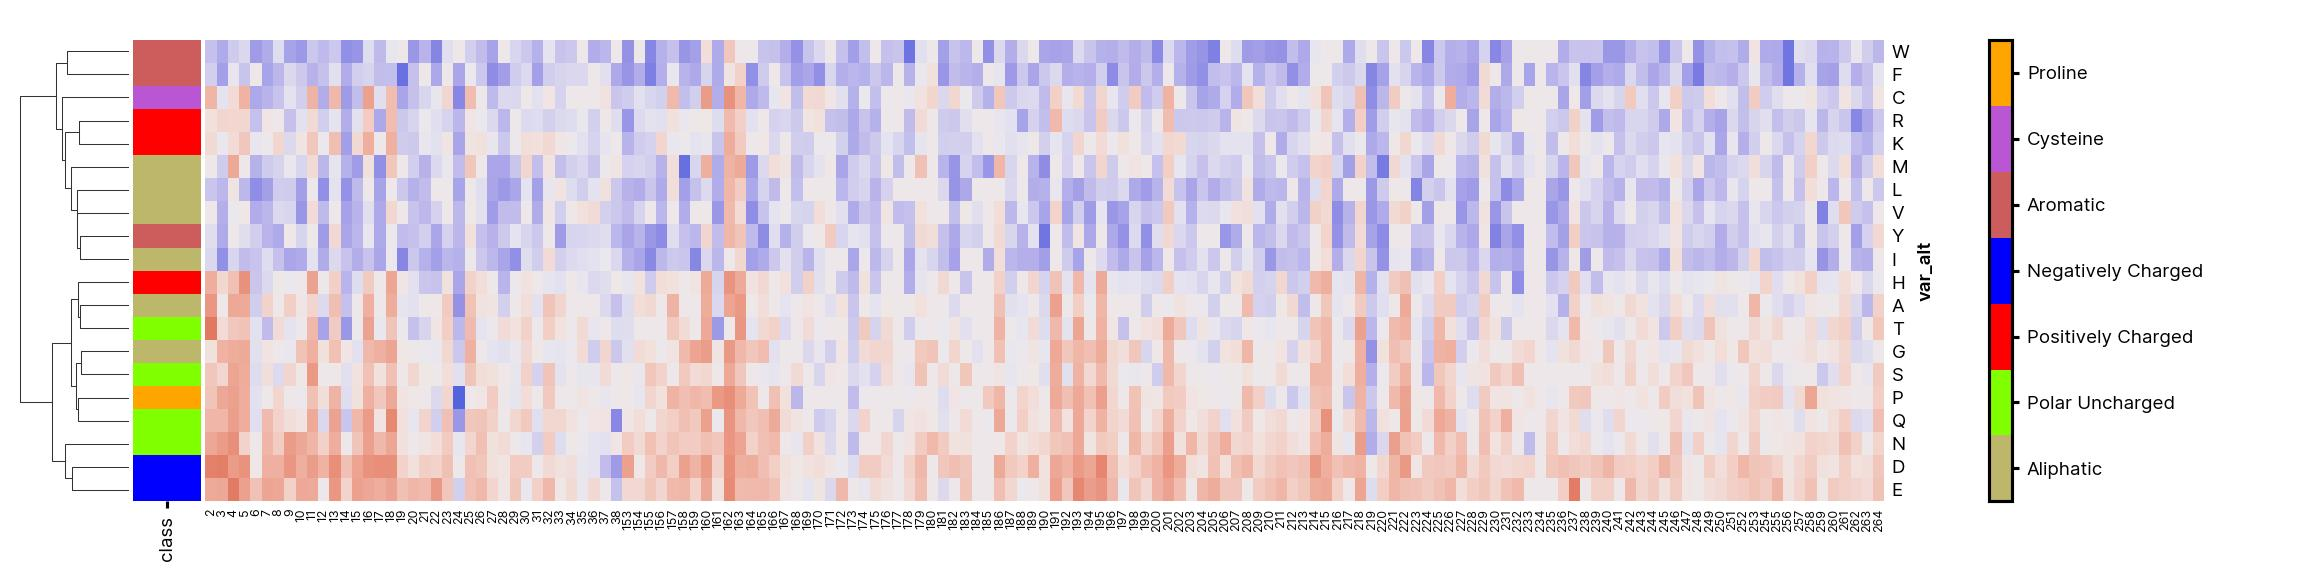

In [25]:
"""
Cluster resiudes in unstructured domain by subsitution residue
"""

data = mean_variant_activity_scores.filter(((polars.col("var_pos") > 152) & (polars.col("var_pos") < 265)) | ((polars.col("var_pos") > 1) & (polars.col("var_pos") < 39))).sort("var_pos").pivot(index=["var_alt"], values="normalized_activity_score_mean", columns="var_pos", maintain_order=True).fill_null(1).to_pandas().set_index("var_alt")

cmap = matplotlib.colormaps.get_cmap("cet_coolwarm")
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.LogNorm(vmin=0.33, vmax=3)

grid = seaborn.clustermap(data, method="average", col_cluster=False, dendrogram_ratio=0.05, cmap=cmap, xticklabels=True, norm=norm, figsize=(16, 4), cbar_pos=None, row_colors=AA_classes.select(["residue", polars.col("color").alias("class")]).to_pandas().set_index("residue"), rasterized=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("AA_colors", list(AA_class_colormap.values()), N=len(AA_class_colormap))

grid.figure.axes[3].tick_params(axis="y", labelrotation=0, length=0)
grid.figure.axes[3].tick_params(axis="x", labelsize=6, length=0)

grid.figure.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax=grid.figure.axes[-1], ticks=numpy.arange(1, len(AA_class_colormap) + 1)/len(AA_class_colormap)-(1/len(AA_class_colormap)/2), format=matplotlib.ticker.FuncFormatter(lambda val, loc: list(AA_class_colormap.keys())[int(val * len(AA_class_colormap))]))

display(Markdown("### Unstructured Domain Clustering"))
grid.figure.savefig(f"output/idr_clustering.svg", bbox_inches="tight")
display(grid.figure)
pyplot.close(grid.figure)

In [26]:
raw_ks_scores = {    "var_ref": [],
    "var_pos": [],
    "var_alt": [],
    "ks_statistic": [],
    "ks_pvalue": [],
    "ks_location": [],
    "ks_sign": [],
}

wt_df = barcode_activity_scores.filter((polars.col("var_ref") == "M") & (polars.col("var_pos") == 1) & (polars.col("var_alt") == "M"))
for (var_ref, var_pos, var_alt), var_df in tqdm(barcode_activity_scores.group_by(["var_ref", "var_pos", "var_alt"])):    
    ks_results = scipy.stats.kstest(var_df["activity_score"], wt_df["activity_score"], alternative="two-sided", method="exact")

    raw_ks_scores["var_ref"].append(var_ref)
    raw_ks_scores["var_pos"].append(var_pos)
    raw_ks_scores["var_alt"].append(var_alt)
    raw_ks_scores["ks_statistic"].append(ks_results.statistic)
    raw_ks_scores["ks_pvalue"].append(ks_results.pvalue)
    raw_ks_scores["ks_location"].append(ks_results.statistic_location)
    raw_ks_scores["ks_sign"].append(ks_results.statistic_sign)

_, raw_ks_scores["ks_fdr_pvalue"] = smtest.fdrcorrection(raw_ks_scores["ks_pvalue"], alpha=0.05, method="indep", is_sorted=False)
    
ks_scores = polars.DataFrame(data=raw_ks_scores, schema={
    "var_ref": polars.Utf8,
    "var_pos": polars.Int64,
    "var_alt": polars.Utf8,
    "ks_statistic": polars.Float64,
    "ks_pvalue": polars.Float64,
    "ks_fdr_pvalue": polars.Float64,
    "ks_location": polars.Float64,
    "ks_sign": polars.Int64,
})
        
display(ks_scores)

0it [00:00, ?it/s]

var_ref,var_pos,var_alt,ks_statistic,ks_pvalue,ks_fdr_pvalue,ks_location,ks_sign
str,i64,str,f64,f64,f64,f64,i64
"""T""",44,"""E""",0.388078,0.000001,0.000021,747.319012,1
"""R""",40,"""H""",0.372225,0.000555,0.002694,806.192914,1
"""P""",197,"""H""",0.189171,0.056801,0.122178,797.856789,1
"""S""",19,"""F""",0.548314,7.5401e-8,0.000002,674.16321,1
"""S""",257,"""F""",0.356775,0.008827,0.026387,416.689881,1
…,…,…,…,…,…,…,…
"""T""",123,"""N""",0.123849,0.739043,0.825314,760.571358,-1
"""P""",172,"""D""",0.331307,0.112896,0.210712,1021.947357,-1
"""T""",123,"""M""",0.217432,0.134395,0.240936,1017.224372,-1


In [27]:
volc_df = mean_variant_activity_scores.filter(polars.col("var_ref") != polars.col("var_alt")).join(
    ks_scores, how="left", on=["var_ref", "var_pos", "var_alt"]
).join(
    clinvar_variant_classifications, how="left", on=["var_ref", "var_pos", "var_alt"]
).sort("simplified_clinical_significance")

display(volc_df)

volc_plot = bokeh.plotting.figure(width=800, height=800, x_axis_label="Normalized Activity Score", y_axis_label="FDR-corrected p-value", tools=["hover", "pan", "wheel_zoom", "save", "reset"], x_axis_type="log", y_axis_type="log", x_range=bokeh.models.Range1d(0.2, 5), y_range=bokeh.models.Range1d(2, 1e-12))

legend_items = []

volc_plot.hover.tooltips = [
    ("Variant", "@var_ref@var_pos@var_alt"),
    ("Activity Score (mean±std)", "@normalized_activity_score_mean±@normalized_activity_score_std"),
    ("p-val", "@ks_pvalue"),
    ("Classification", "@clinical_significance (@simplified_clinical_significance)"),
]

color_map = {
    "Benign": "#00d00080",
    "Conflicting": "#8b800080",
    "Pathogenic": "#ff000080",
    "VUS": "#a0a0a080"
}

for ((clinical_significance,), df), color in zip(volc_df.group_by(["curated_clinical_significance"]), colorcet.glasbey_dark):
    if clinical_significance is None:
        renderer = volc_plot.scatter(source=bokeh.models.ColumnDataSource(df.to_pandas()), x="normalized_activity_score_mean", y="ks_fdr_pvalue", size=5, color="#000000", alpha=0.05)
        legend_items.append(("None", [renderer]))
    else:
        renderer = volc_plot.scatter(source=bokeh.models.ColumnDataSource(df.to_pandas()), x="normalized_activity_score_mean", y="ks_fdr_pvalue", size=10, color=color_map[clinical_significance])
        legend_items.append((clinical_significance, [renderer]))

legend = bokeh.models.Legend(items=legend_items, orientation="horizontal", nrows=2)
legend.click_policy = "hide"
volc_plot.add_layout(legend, "above")

sig = bokeh.models.Span(location=0.05, dimension="width", line_color='#000000', line_dash="dotted", line_width=1)
volc_plot.add_layout(sig)
fc_wt = bokeh.models.Span(location=1, dimension="height", line_color='#000000', line_dash="dotted", line_width=1)
volc_plot.add_layout(fc_wt)

display(Markdown("## Classification Volcano Plot (DMS)"))
bokeh.io.show(volc_plot)

var_ref,var_pos,var_alt,activity_score_mean,activity_score_std,measurement_count,normalized_activity_score_mean,normalized_activity_score_std,ks_statistic,ks_pvalue,ks_fdr_pvalue,ks_location,ks_sign,clinical_significance,simplified_clinical_significance,curated_clinical_significance,accession
str,i64,str,f64,f64,u32,f64,f64,f64,f64,f64,f64,i64,str,str,str,str
"""M""",2,"""D""",1565.513525,172.693927,29,1.832481,0.290824,0.658317,8.0030e-13,1.1431e-10,1158.551979,-1,null,null,null,null
"""M""",2,"""G""",929.557204,183.082587,34,1.075135,0.152257,0.125172,0.617928,0.734206,577.360713,-1,null,null,null,null
"""M""",2,"""R""",925.65043,129.603899,33,1.079553,0.162236,0.127146,0.616358,0.733,706.330409,-1,null,null,null,null
"""M""",2,"""W""",631.263607,253.791415,17,0.734639,0.281695,0.273415,0.129985,0.234942,422.697129,1,null,null,null,null
"""M""",2,"""Y""",761.840943,104.965612,57,0.887118,0.114115,0.173686,0.057428,0.123278,552.785856,1,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""A""",174,"""V""",646.675435,85.600173,27,0.757157,0.131987,0.243803,0.067818,0.141277,540.892533,1,"""VUS""","""VUS""","""VUS""","""VCV001404902"""
"""A""",189,"""T""",952.13715,95.60934,45,1.107414,0.089588,0.136827,0.339301,0.480109,652.610088,-1,"""VUS""","""VUS""","""VUS""","""VCV001410915"""
"""M""",193,"""K""",988.499859,71.855582,20,1.149249,0.014048,0.215935,0.268536,0.406212,1267.767036,-1,"""VUS""","""VUS""","""VUS""","""VCV001352289"""


## Classification Volcano Plot (DMS)

## Classification Volcano Plot (DMS)

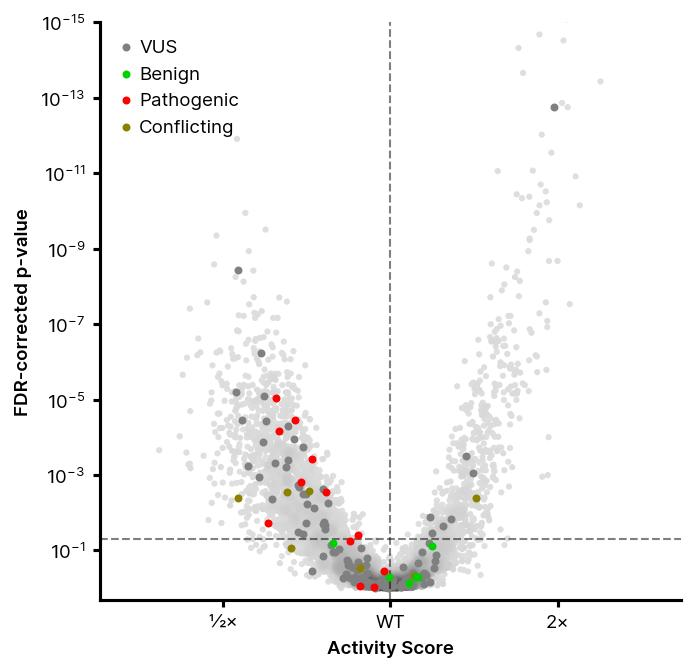

In [28]:
volc_df = mean_variant_activity_scores.filter(polars.col("var_ref") != polars.col("var_alt")).join(
    ks_scores, how="left", on=["var_ref", "var_pos", "var_alt"]
).join(
    clinvar_variant_classifications, how="left", on=["var_ref", "var_pos", "var_alt"]
).sort("simplified_clinical_significance")

figure, axis = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(5, 5))

color_map = {
    "Benign": "#00d000",
    "Conflicting": "#8b8000",
    "Pathogenic": "#ff0000",
    "VUS": "#808080"
}

zorder_map = {
    "Benign": 4,
    "Conflicting": 2,
    "Pathogenic": 3,
    "VUS": 1
}

xlim=(0.3, 3.33)
ylim=(2, 1e-15)
bins = (numpy.geomspace(start=xlim[0], stop=xlim[1], num=80), numpy.geomspace(start=ylim[1], stop=ylim[0], num=80))
weights, color_normalizer = calc_weights_for_scatter(volc_df["normalized_activity_score_mean"].to_numpy(), volc_df["ks_fdr_pvalue"].to_numpy(), bins=bins)

volc_df = volc_df.with_columns([
    polars.Series(weights).alias("scatter_weights")
])

for (clinical_significance,), df in volc_df.group_by(["simplified_clinical_significance"]):
    if clinical_significance is None:
        axis.scatter(**reorder_points_and_weights(df["normalized_activity_score_mean"].to_numpy(), df["ks_fdr_pvalue"].to_numpy(), df["scatter_weights"].to_numpy()), cmap=cm_light_to_gray, norm=color_normalizer, s=4, marker="o", rasterized=True, zorder=0)
    else:
        axis.scatter(df["normalized_activity_score_mean"], df["ks_fdr_pvalue"], color=color_map[clinical_significance], s=8, marker="o", rasterized=False, label=f"{clinical_significance}", zorder=zorder_map[clinical_significance])

axis.set(xlabel="Activity Score", ylabel="FDR-corrected p-value", xlim=xlim, ylim=ylim)
axis.set_xscale("log", base=10)
axis.set_yscale("log", base=10)
axis.axhline(0.05, linestyle="--", linewidth=1, color="#00000080")
axis.axvline(1, linestyle="--", linewidth=1, color="#00000080")
axis.tick_params(axis="x", which="minor", bottom=False)
axis.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
axis.set_xticks([0.5, 1, 2])
axis.set_xticklabels(["½×", "WT", "2×"])
axis.legend(loc="upper left")
        
figure.savefig(f"output/classification_volcano_plot.svg", bbox_inches="tight")
display(Markdown("## Classification Volcano Plot (DMS)"))
display(figure)
pyplot.close(figure)

In [29]:
# Clipped variants

volc_df.filter(polars.col("ks_fdr_pvalue") < ylim[1])

var_ref,var_pos,var_alt,activity_score_mean,activity_score_std,measurement_count,normalized_activity_score_mean,normalized_activity_score_std,ks_statistic,ks_pvalue,ks_fdr_pvalue,ks_location,ks_sign,clinical_significance,simplified_clinical_significance,curated_clinical_significance,accession,scatter_weights
str,i64,str,f64,f64,u32,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,f64
"""F""",296,"""G""",1719.299903,300.784578,34,1.99192,0.251543,0.738759,1.6749e-19,8.8517e-17,1448.569938,-1,null,null,null,null,0.0
"""F""",278,"""P""",1639.682865,95.931005,63,1.912772,0.161119,0.642675,1.0160e-25,1.7898e-22,1234.536652,-1,null,null,null,null,0.0
"""Y""",280,"""E""",1601.276633,184.101841,57,1.859555,0.12975,0.655695,2.0651e-24,1.8191e-21,1443.777006,-1,null,null,null,null,0.0
"""W""",294,"""E""",1797.746842,233.745066,49,2.088944,0.211478,0.715122,9.5771e-26,1.7898e-22,1315.676281,-1,null,null,null,null,0.0
"""Y""",4,"""E""",1623.516521,58.038859,55,1.893397,0.123109,0.669019,1.1178e-24,1.1815e-21,1345.274344,-1,null,null,null,null,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""W""",276,"""Q""",1619.48282,59.994373,55,1.888895,0.126955,0.691603,1.2256e-26,6.4774e-23,1412.055879,-1,null,null,null,null,0.0
"""F""",278,"""Q""",1778.295886,105.360523,24,2.074819,0.184613,0.8242,2.0854e-18,8.4778e-16,1520.165875,-1,null,null,null,null,0.0
"""F""",278,"""T""",1587.095196,234.108387,43,1.842448,0.206953,0.659976,7.6802e-19,3.3825e-16,1230.375667,-1,null,null,null,null,0.0


In [30]:
classifications = mean_variant_activity_scores.join(
    ks_scores, how="left", on=["var_ref", "var_pos", "var_alt"]
).with_columns([
    polars.when(
        (polars.col("ks_fdr_pvalue") < 0.05) & (polars.col("normalized_activity_score_mean") < 1)
    ).then(polars.lit("low_activity")).when(
        (polars.col("ks_fdr_pvalue") < 0.05) & (polars.col("normalized_activity_score_mean") > 1)
    ).then(polars.lit("high_activity")).otherwise(polars.lit("non-significant")).alias("classification")
])

display(classifications)

var_ref,var_pos,var_alt,activity_score_mean,activity_score_std,measurement_count,normalized_activity_score_mean,normalized_activity_score_std,ks_statistic,ks_pvalue,ks_fdr_pvalue,ks_location,ks_sign,classification
str,i64,str,f64,f64,u32,f64,f64,f64,f64,f64,f64,i64,str
"""M""",1,"""M""",859.839157,56.482163,12664,1.0,0.0,0.0,1.0,1.0,37.263325,1,"""non-significan…"
"""M""",2,"""D""",1565.513525,172.693927,29,1.832481,0.290824,0.658317,8.0030e-13,1.1431e-10,1158.551979,-1,"""high_activity"""
"""M""",2,"""G""",929.557204,183.082587,34,1.075135,0.152257,0.125172,0.617928,0.734206,577.360713,-1,"""non-significan…"
"""M""",2,"""R""",925.65043,129.603899,33,1.079553,0.162236,0.127146,0.616358,0.733,706.330409,-1,"""non-significan…"
"""M""",2,"""W""",631.263607,253.791415,17,0.734639,0.281695,0.273415,0.129985,0.234942,422.697129,1,"""non-significan…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Q""",297,"""V""",557.512212,94.995151,28,0.655348,0.150678,0.336161,0.002561,0.009464,583.850352,1,"""low_activity"""
"""I""",298,"""S""",1590.169619,124.600055,37,1.85416,0.176194,0.596229,4.7620e-13,7.1907e-11,1113.030839,-1,"""high_activity"""
"""I""",298,"""W""",1017.753191,163.871343,32,1.18339,0.171869,0.206747,0.112815,0.210712,956.968517,-1,"""non-significan…"


In [31]:
out_table = classifications.join(
    clinvar_variant_classifications, how="left", on=["var_ref", "var_pos", "var_alt"]
).sort(["var_pos", "var_alt"])

display(out_table)

simplified_out_table = out_table.select([
    "var_ref",
    "var_pos",
    "var_alt",
    "normalized_activity_score_mean",
    "normalized_activity_score_std",
    "ks_fdr_pvalue",
    "classification",
    "simplified_clinical_significance"
]).filter(polars.col("var_ref") != polars.col("var_alt"))

simplified_out_table.write_csv("output/crx_activity_scores.tsv", separator="\t")
simplified_out_table.write_parquet("output/crx_activity_scores.parquet")

var_ref,var_pos,var_alt,activity_score_mean,activity_score_std,measurement_count,normalized_activity_score_mean,normalized_activity_score_std,ks_statistic,ks_pvalue,ks_fdr_pvalue,ks_location,ks_sign,classification,clinical_significance,simplified_clinical_significance,curated_clinical_significance,accession
str,i64,str,f64,f64,u32,f64,f64,f64,f64,f64,f64,i64,str,str,str,str,str
"""M""",1,"""M""",859.839157,56.482163,12664,1.0,0.0,0.0,1.0,1.0,37.263325,1,"""non-significan…",null,null,null,null
"""M""",2,"""A""",1399.205895,192.195637,28,1.633055,0.253171,0.58298,1.5055e-9,9.5860e-8,1104.311864,-1,"""high_activity""",null,null,null,null
"""M""",2,"""C""",1189.548157,180.24695,27,1.378047,0.137264,0.37378,0.00069,0.003207,1272.050126,-1,"""high_activity""",null,null,null,null
"""M""",2,"""D""",1565.513525,172.693927,29,1.832481,0.290824,0.658317,8.0030e-13,1.1431e-10,1158.551979,-1,"""high_activity""",null,null,null,null
"""M""",2,"""E""",1251.910298,57.366135,15,1.4601,0.108482,0.424563,0.005764,0.018508,1151.790614,-1,"""high_activity""",null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""L""",299,"""Q""",1339.867048,277.637817,24,1.555732,0.304801,0.46594,0.000028,0.000232,1033.74383,-1,"""high_activity""",null,null,null,null
"""L""",299,"""R""",1226.842647,156.257418,12,1.428002,0.170481,0.461834,0.007345,0.022599,878.804861,-1,"""high_activity""",null,null,null,null
"""L""",299,"""S""",1174.923521,232.650117,16,1.357673,0.194003,0.405441,0.006923,0.021561,1328.028034,-1,"""high_activity""",null,null,null,null


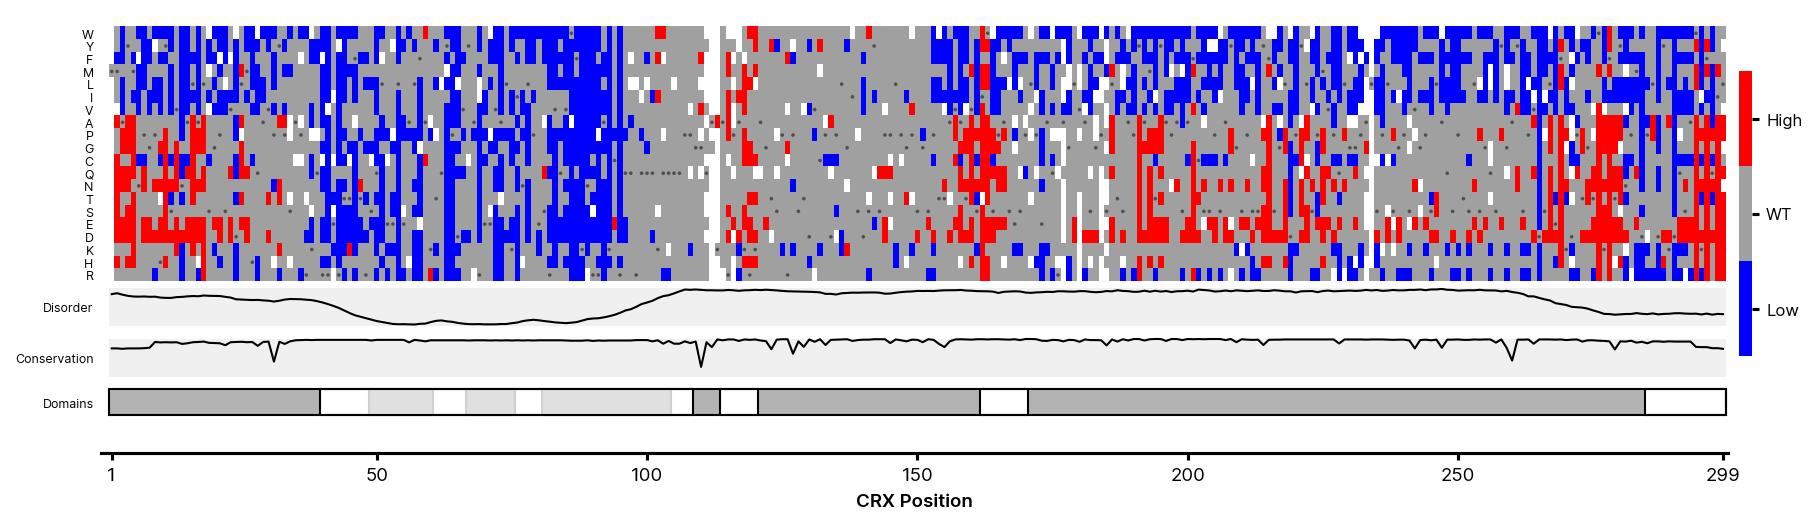

In [32]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("threecolor", ["#0000ff", "#a0a0a0", "#ff0000"], N=3)
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], ncolors=3)

heatmap_data = classifications.with_columns([
    polars.col("classification").replace({
        "low_activity": -1,
        "non-significant": 0,
        "high_activity": 1
    }, default=None).alias("numeric_classification")
])

figure, axis, colorbar = make_heatmap_figure(heatmap_data, "numeric_classification", cmap, norm, 0, plot_average=False)

colorbar.ax.set_yticks([-1, 0, 1]) 
colorbar.ax.set_yticklabels(["Low", "WT", "High"])

figure.savefig(f"output/classification_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

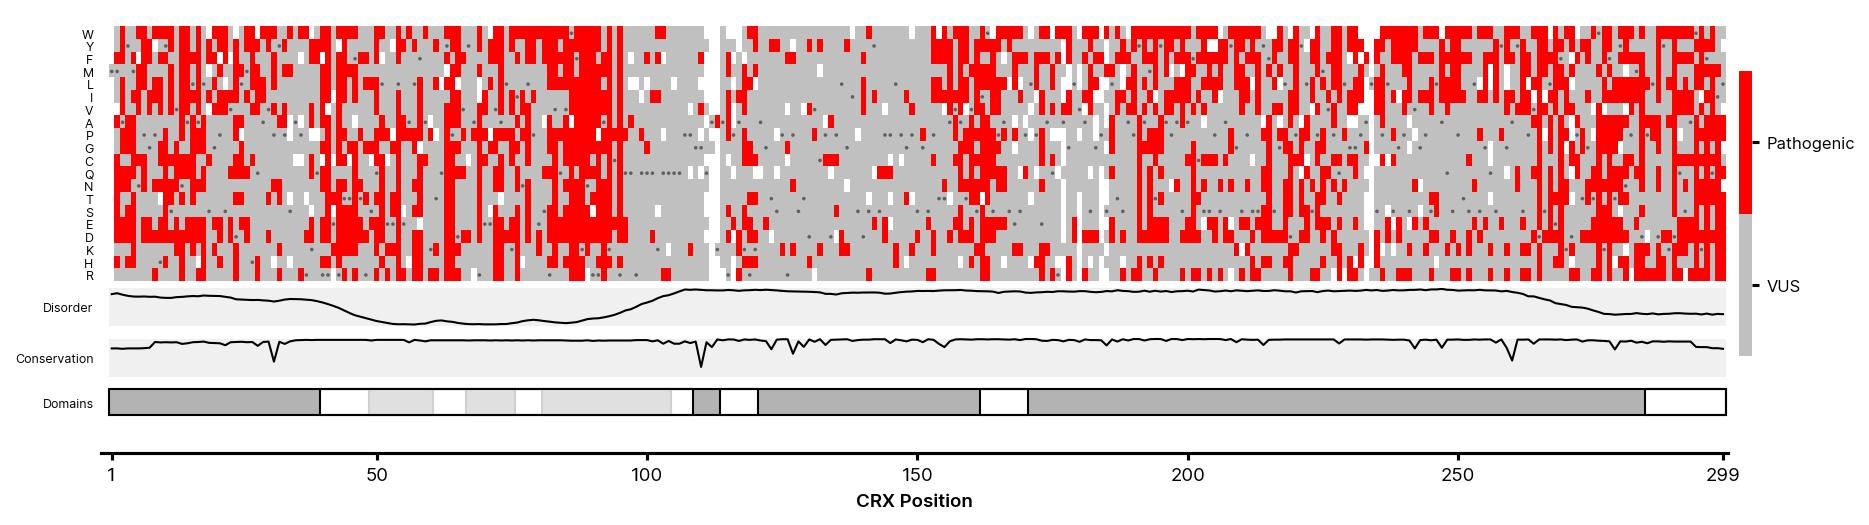

In [33]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("vus_pathogenic", ["#c0c0c0", "#ff0000"], N=2)
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5], ncolors=2)

heatmap_data = classifications.with_columns([
    polars.col("classification").replace({
        "low_activity": 1,
        "non-significant": 0,
        "high_activity": 1
    }, default=None).alias("numeric_classification")
])

figure, axis, colorbar = make_heatmap_figure(heatmap_data, "numeric_classification", cmap, norm, 0, plot_average=False)

colorbar.ax.set_yticks([0, 1]) 
colorbar.ax.set_yticklabels(["VUS", "Pathogenic"])

figure.savefig(f"output/DMS_classification_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

## Local Hydrophobic Density

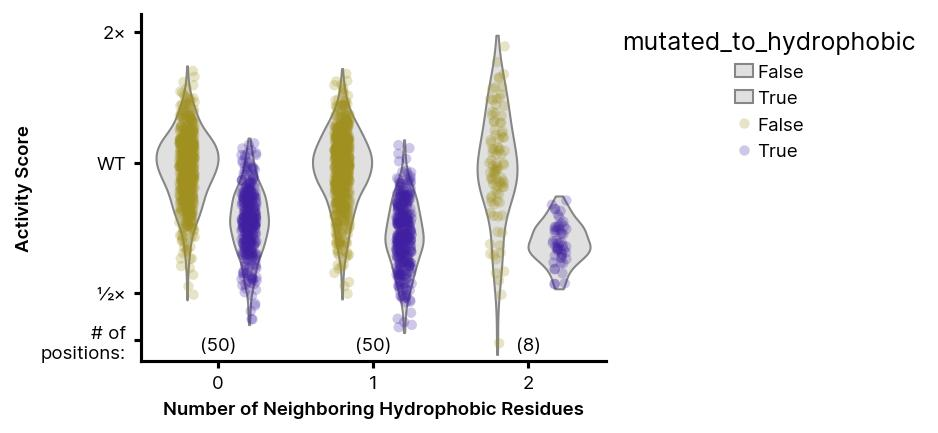

**LR Test**: stat=13.509, pval=2.374e-04

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     normalized_activity_score_mean   R-squared:                       0.374
Model:                                        OLS   Adj. R-squared:                  0.373
Method:                             Least Squares   F-statistic:                     377.4
Date:                            Thu, 21 Mar 2024   Prob (F-statistic):          3.83e-192
Time:                                    13:03:04   Log-Likelihood:                 619.80
No. Observations:                            1899   AIC:                            -1232.
Df Residuals:                                1895   BIC:                            -1209.
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          0.9884      0.007    139.170      0.000       0.974       1.002
C(mutated_to_hydrophobic)[T.True]                                 -0.2482      0.012    -21.092      0.000      -0.271      -0.225
num_neighboring_hydrophobics                                       0.0042      0.008      0.525      0.599      -0.012       0.020
num_neighboring_hydrophobics:C(mutated_to_hydrophobic)[T.True]    -0.0491      0.013     -3.678      0.000      -0.075      -0.023
==============================================================================
Omnibus:                       60.709   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.626
Skew:                           0.311   Prob(JB):                     3.45e-20
Kurtosis:                       3.864   Cond. No.                         5.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
hydrophobics = polars.Series(values=list("FWYMILV"))

def clamp(value, limits=(0, len(CRX_WT_AA))):
    if value < limits[0]:
        return limits[0]
    elif value > limits[1]:
        return limits[1]
    else:
        return value

def count_nearby_hydrophobics(position: int, distance: int = 1) -> int:
    neighboring_aas = CRX_WT_AA[clamp(position-distance-1):clamp(position-1)] + CRX_WT_AA[clamp(position):clamp(position+distance)]
    return sum([aa in hydrophobics for aa in neighboring_aas])

raw_nearby_hydrophobics_table = []
for i in range(len(CRX_WT_AA)):
    raw_nearby_hydrophobics_table.append((i, count_nearby_hydrophobics(i)))
nearby_hydrophobics_table = polars.DataFrame(raw_nearby_hydrophobics_table, schema=["var_pos", "num_neighboring_hydrophobics"])

hydrophobic_data = mean_variant_activity_scores.filter(
    (
        ((polars.col("var_pos") > 152) & (polars.col("var_pos") < 265)) |
        ((polars.col("var_pos") > 1) & (polars.col("var_pos") < 39))
    ) &
    polars.col("var_ref").is_in(hydrophobics).not_()
).with_columns([
    polars.col("var_alt").is_in(hydrophobics).alias("mutated_to_hydrophobic")
]).join(nearby_hydrophobics_table, how="left", on="var_pos")

figure, axis = pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(4, 3))

seaborn.violinplot(ax=axis, data=hydrophobic_data.to_pandas(), hue="mutated_to_hydrophobic", palette=["#e0e0e0", "#e0e0e0"], y="normalized_activity_score_mean", x="num_neighboring_hydrophobics", dodge=True, log_scale=True, inner=None, linewidth=1, cut=0.5)
seaborn.stripplot(ax=axis, data=hydrophobic_data.to_pandas(), hue="mutated_to_hydrophobic", palette=["#a09020", "#4020a0"], y="normalized_activity_score_mean", x="num_neighboring_hydrophobics", dodge=True, alpha=0.25, edgecolor="none", rasterized=True)

axis.set(ylim=(0.35, 2.2), xlabel="Number of Neighboring Hydrophobic Residues", ylabel="Activity Score")
axis.set_yscale("log")
axis.set_yticks([0.39, 0.5, 1, 2])
axis.set_yticklabels(["# of\npositions:", "½×", "WT", "2×"]) 
axis.minorticks_off()

seaborn.move_legend(axis, "upper left", bbox_to_anchor=(1, 1))

for num_neighboring_hydrophobics, count in hydrophobic_data.group_by(["num_neighboring_hydrophobics"]).agg([
    polars.col("var_pos").unique().count()
]).sort(["num_neighboring_hydrophobics"]).iter_rows():
    axis.text(num_neighboring_hydrophobics, 0.37, f"({count})", fontsize=9, horizontalalignment="center")

figure.savefig(f"output/local_hydrophobic_density.svg", bbox_inches="tight")
display(Markdown("## Local Hydrophobic Density"))
display(figure)
pyplot.close(figure)

full_model = smfapi.ols('normalized_activity_score_mean ~ num_neighboring_hydrophobics*C(mutated_to_hydrophobic)', data=hydrophobic_data.to_pandas()).fit()
reduced_model = smfapi.ols('normalized_activity_score_mean ~ num_neighboring_hydrophobics+C(mutated_to_hydrophobic)', data=hydrophobic_data.to_pandas()).fit()

lr_stat, pvalue, df_diff = full_model.compare_lr_test(reduced_model)
display(Markdown(f"**LR Test**: stat={lr_stat:.3f}, pval={pvalue:.3e}"))
display(full_model.summary())

# Computational Variant Predictors

In [35]:
"""
Read in AlphaMissense activity scores
"""

am_variant_scores = polars.read_csv("external_data_sources/AlphaMissense_CRX.tsv", separator="\t").with_columns([
    polars.col("am_classification").cast(polars.Categorical)
])

display(am_variant_scores)

var_ref,var_pos,var_alt,am_score,am_classification
str,i64,str,f64,cat
"""M""",1,"""A""",0.575,"""pathogenic"""
"""M""",1,"""C""",0.4221,"""ambiguous"""
"""M""",1,"""D""",0.9782,"""pathogenic"""
"""M""",1,"""E""",0.8964,"""pathogenic"""
"""M""",1,"""F""",0.3435,"""ambiguous"""
…,…,…,…,…
"""L""",299,"""S""",0.9738,"""pathogenic"""
"""L""",299,"""T""",0.9156,"""pathogenic"""
"""L""",299,"""V""",0.4642,"""ambiguous"""


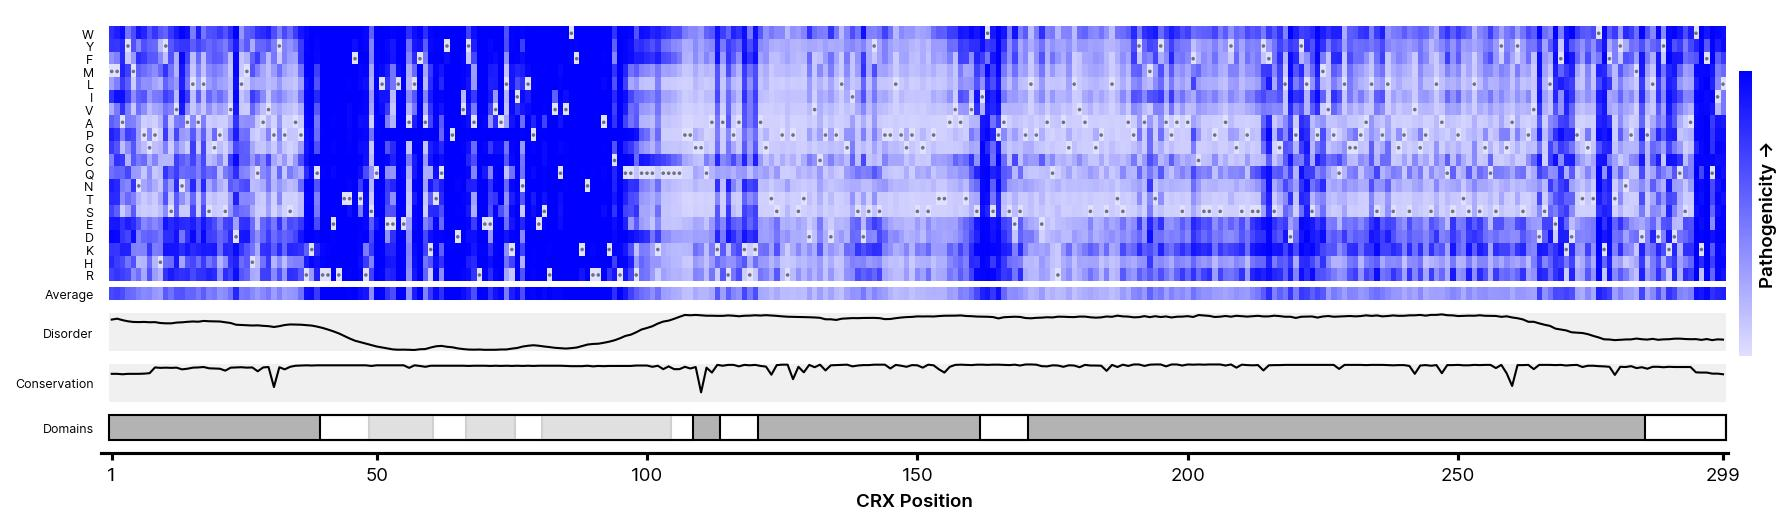

In [36]:
cmap = cm_light_to_blue
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

figure, axis, colorbar = make_heatmap_figure(am_variant_scores, "am_score", cmap, norm, 0.0, plot_average=True)

colorbar.set_label("Pathogenicity →")
colorbar.ax.set_yticks([])

figure.savefig(f"output/AlphaMissense_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

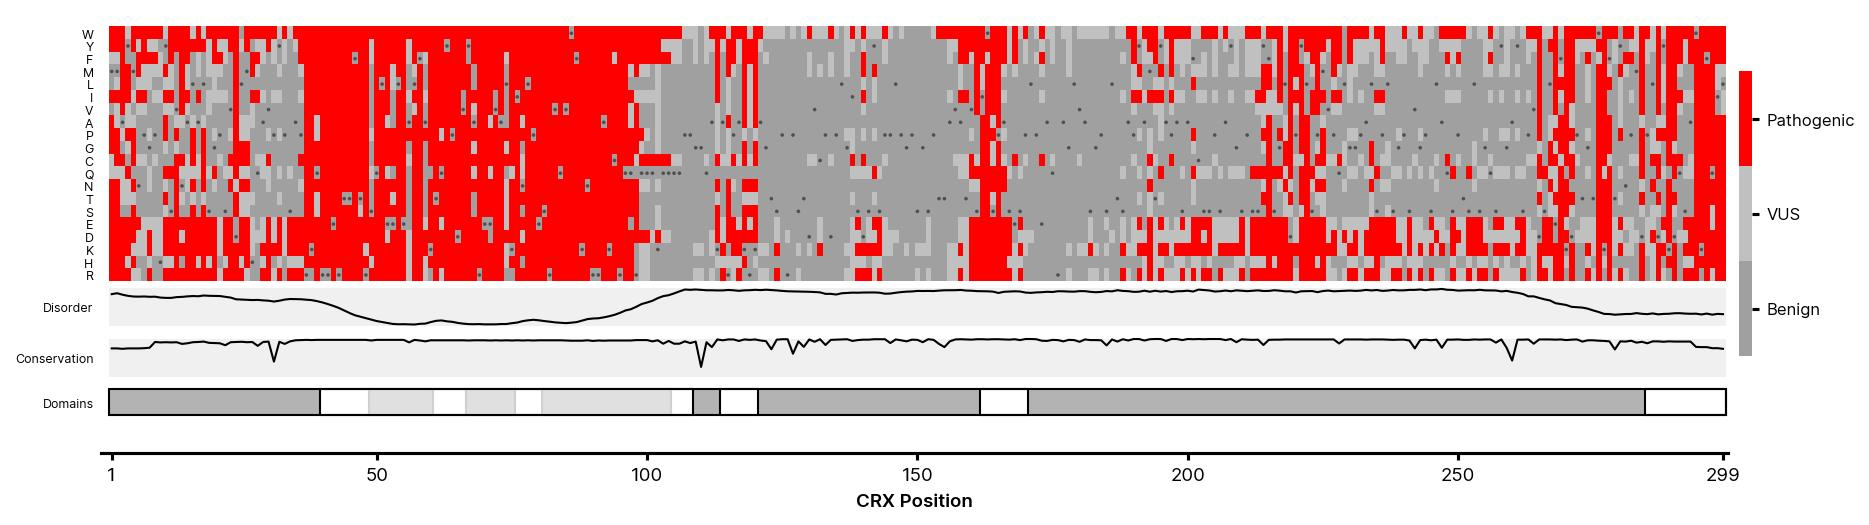

In [37]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("benign_vus_path", ["#a0a0a0", "#c0c0c0", "#ff0000"], N=3)
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], ncolors=3)

heatmap_data = am_variant_scores.with_columns([
    polars.col("am_classification").replace({
        "benign": -1,
        "ambiguous": 0,
        "pathogenic": 1
    }, default=None).alias("numeric_classification")
])

figure, axis, colorbar = make_heatmap_figure(heatmap_data, "numeric_classification", cmap, norm, -1, plot_average=False)

colorbar.ax.set_yticks([-1, 0, 1]) 
colorbar.ax.set_yticklabels(["Benign", "VUS", "Pathogenic"])

figure.savefig(f"output/AlphaMissense_classification_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

In [38]:
"""
Read in EVE activity scores
"""

eve_variant_scores = polars.read_csv("external_data_sources/EVE_CRX_scores.csv")

display(eve_variant_scores)

wt_aa,position,mt_aa,ClinVar_ClinicalSignificance,Gold_Stars,NumberSubmitters,Starred_Coarse_Grained_Clin_Sig,frequency_gv2,frequency_gv3,evolutionary_index_ASM,EVE_scores_ASM,uncertainty_ASM,EVE_classes_10_pct_retained_ASM,EVE_classes_20_pct_retained_ASM,EVE_classes_30_pct_retained_ASM,EVE_classes_40_pct_retained_ASM,EVE_classes_50_pct_retained_ASM,EVE_classes_60_pct_retained_ASM,EVE_classes_70_pct_retained_ASM,EVE_classes_80_pct_retained_ASM,EVE_classes_90_pct_retained_ASM,EVE_classes_25_pct_retained_ASM,EVE_classes_75_pct_retained_ASM,evolutionary_index_BPU,EVE_scores_BPU,uncertainty_BPU,EVE_classes_75_pct_retained_BPU,BS1,PM2,PM5,PP5,BP6,b_model,p_model,b_acmg_model,lb_acmg_model,lp_acmg_model,coarse_clinical_significance_post,clinical_significance_post,model_disagreement,CV_label_and_model_combined_with_other_evidence_disagreement,starred_label_and_model_disagreement,starred_label_and_model_combined_with_other_evidence_disagreement
str,i64,str,str,f64,f64,str,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,str,str,bool,bool,bool,bool
"""M""",1,"""A""",null,null,null,null,null,null,7.4835205,0.44956,0.68805,"""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""",null,null,null,null,false,true,false,false,false,false,false,false,false,false,null,null,false,false,false,false
"""M""",1,"""C""",null,null,null,null,null,null,7.2526245,0.422493,0.681084,"""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Benign""","""Uncertain""","""Uncertain""",null,null,null,null,false,true,false,false,false,false,false,false,false,false,null,null,false,false,false,false
"""M""",1,"""D""",null,null,null,null,null,null,7.300476,0.425971,0.682146,"""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Benign""","""Uncertain""","""Uncertain""",null,null,null,null,false,true,false,false,false,false,false,false,false,false,null,null,false,false,false,false
"""M""",1,"""E""",null,null,null,null,null,null,7.5230103,0.46068,0.690052,"""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""",null,null,null,null,false,true,false,false,false,false,false,false,false,false,null,null,false,false,false,false
"""M""",1,"""F""",null,null,null,null,null,null,7.644348,0.524458,0.69195,"""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""",null,null,null,null,false,true,false,false,false,false,false,false,false,false,null,null,false,false,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""L""",299,"""S""",null,null,null,null,null,null,7.843689,0.670567,0.633777,"""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Pathogenic""","""Pathogenic""","""Pathogenic""","""Uncertain""","""Pathogenic""",null,null,null,null,false,true,false,false,false,false,true,false,false,true,"""pathogenic""","""Likely Pathoge…",false,false,false,false
"""L""",299,"""T""",null,null,null,null,null,null,8.055847,0.740603,0.572426,"""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Pathogenic""","""Pathogenic""","""Pathogenic""","""Pathogenic""","""Uncertain""","""Pathogenic""",null,null,null,null,false,true,false,false,false,false,true,false,false,true,"""pathogenic""","""Likely Pathoge…",false,false,false,false
"""L""",299,"""V""",null,null,null,null,null,null,7.9559937,0.71742,0.595374,"""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Uncertain""","""Pathogenic"""

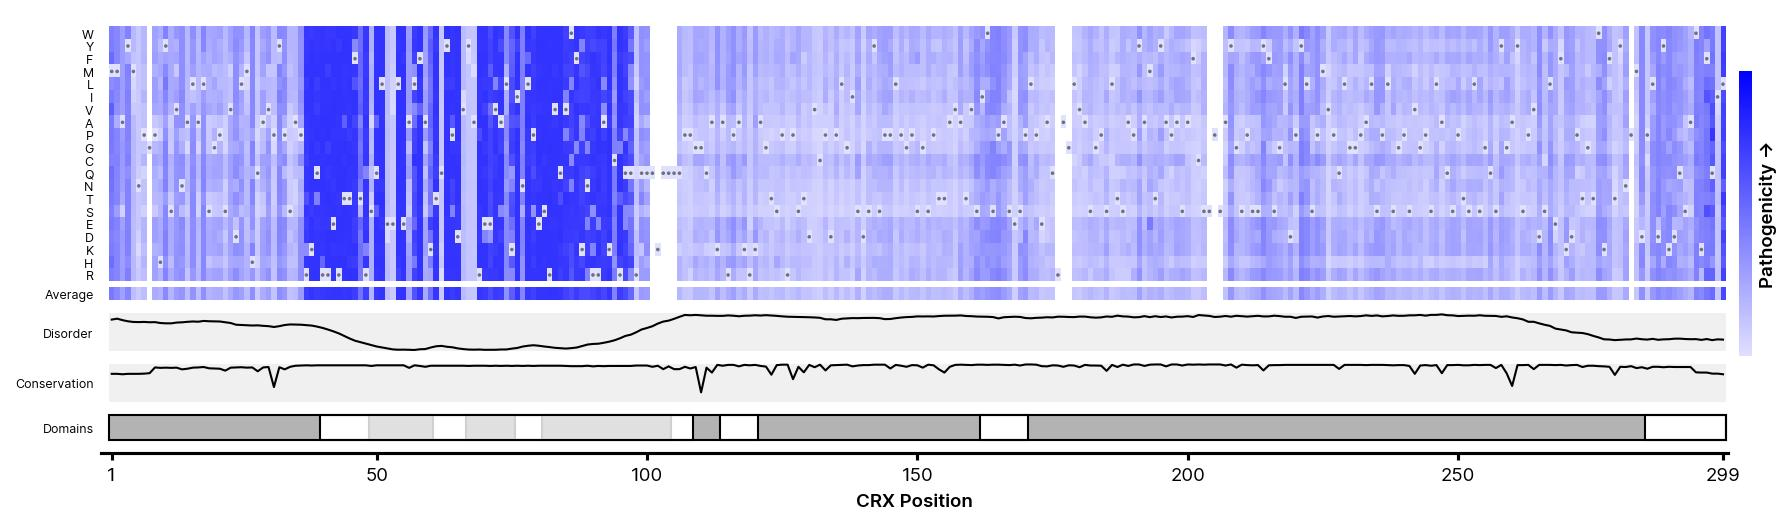

In [39]:
cmap = cm_light_to_blue
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

figure, axis, colorbar = make_heatmap_figure(eve_variant_scores.select([
    polars.col("wt_aa").alias("var_ref"),
    polars.col("position").alias("var_pos"),
    polars.col("mt_aa").alias("var_alt"),
    polars.col("EVE_scores_ASM"),
    polars.col("EVE_classes_75_pct_retained_ASM")
]), "EVE_scores_ASM", cmap, norm, 0.0, plot_average=True)

colorbar.set_label("Pathogenicity →")
colorbar.ax.set_yticks([])

figure.savefig(f"output/EVE_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

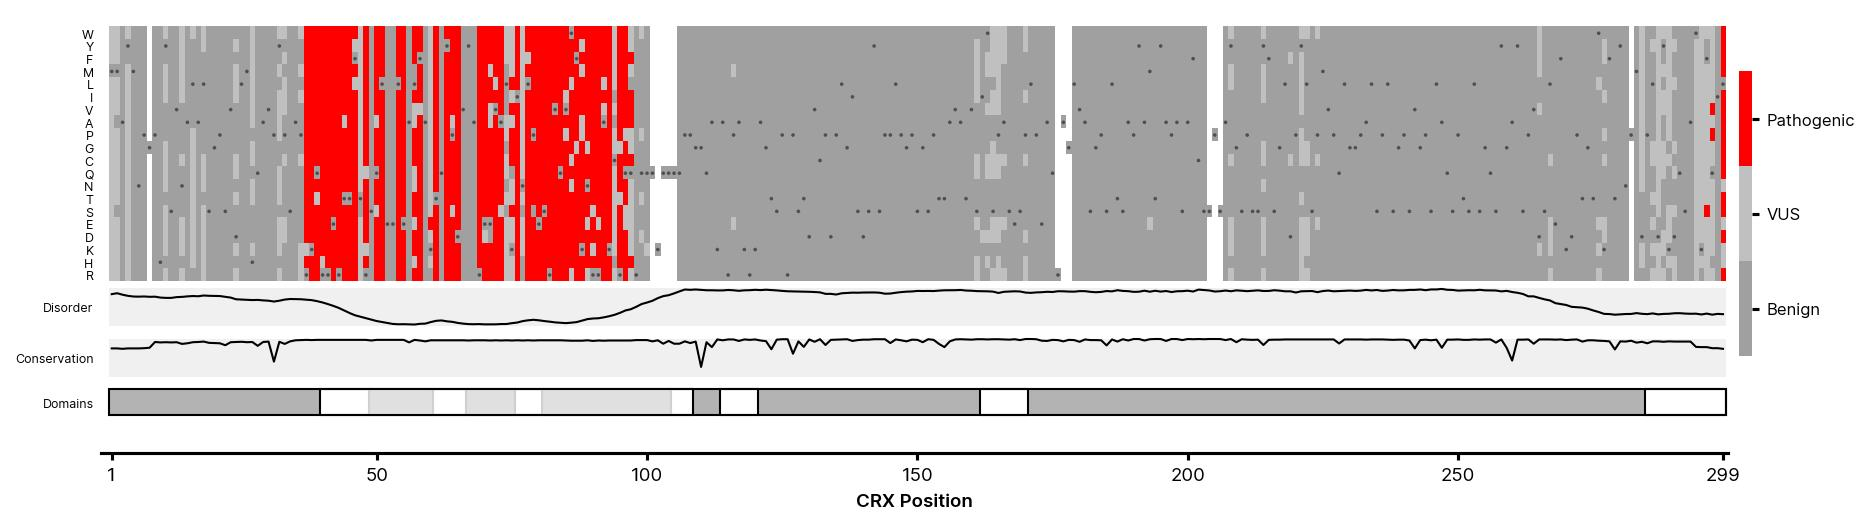

In [40]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("benign_vus_path", ["#a0a0a0", "#c0c0c0", "#ff0000"], N=3)
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], ncolors=3)

heatmap_data = eve_variant_scores.select([
    polars.col("wt_aa").alias("var_ref"),
    polars.col("position").alias("var_pos"),
    polars.col("mt_aa").alias("var_alt"),
    polars.col("EVE_scores_ASM"),
    polars.col("EVE_classes_75_pct_retained_ASM").replace({
        "Benign": -1,
        "Uncertain": 0,
        "Pathogenic": 1
    }, default=None).alias("numeric_classification")
])

figure, axis, colorbar = make_heatmap_figure(heatmap_data, "numeric_classification", cmap, norm, -1, plot_average=False)

colorbar.ax.set_yticks([-1, 0, 1]) 
colorbar.ax.set_yticklabels(["Benign", "VUS", "Pathogenic"])

figure.savefig(f"output/EVE_classification_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

In [41]:
"""
Read in ESM1b scores
"""

esm1b_variant_scores = polars.read_csv("external_data_sources/ESM1b_CRX_scores.csv")

display(esm1b_variant_scores)

var_ref,var_pos,var_alt,score
str,i64,str,f64
"""M""",1,"""K""",-15.054
"""M""",1,"""R""",-14.602
"""M""",1,"""H""",-14.794
"""M""",1,"""E""",-14.623
"""M""",1,"""D""",-14.745
…,…,…,…
"""L""",299,"""M""",-7.365
"""L""",299,"""P""",-10.919
"""L""",299,"""Y""",-13.303


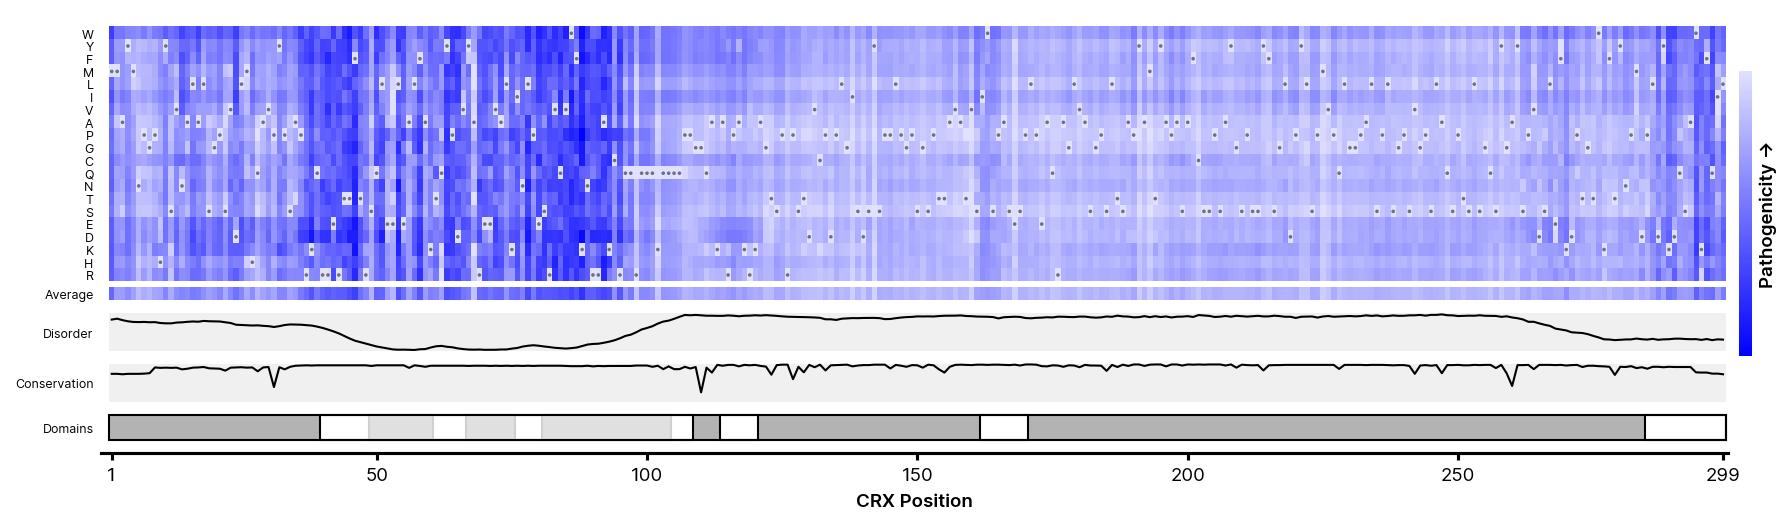

In [42]:
cmap = cm_light_to_blue.reversed()
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.Normalize(vmin=-25, vmax=0)

figure, axis, colorbar = make_heatmap_figure(esm1b_variant_scores, "score", cmap, norm, 0.0, plot_average=True)

colorbar.set_label("Pathogenicity →")
colorbar.ax.set_yticks([])

figure.savefig(f"output/ESM1b_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)

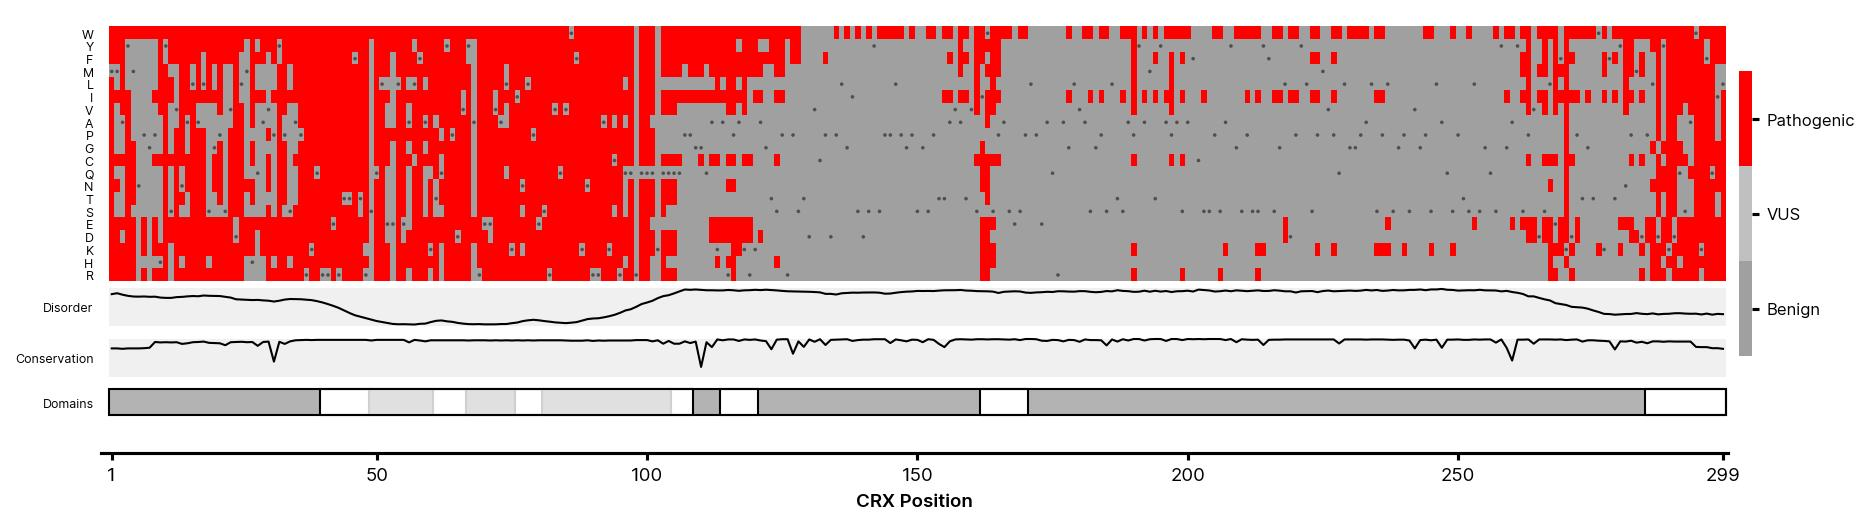

In [43]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("benign_vus_path", ["#a0a0a0", "#c0c0c0", "#ff0000"], N=3)
cmap.set_bad("#ffffff00")
norm = matplotlib.colors.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], ncolors=3)

heatmap_data = esm1b_variant_scores.with_columns([
    polars.when(polars.col("score") < -7.5).then(1).otherwise(-1).alias("numeric_classification")
])

figure, axis, colorbar = make_heatmap_figure(heatmap_data, "numeric_classification", cmap, norm, -1, plot_average=False)

colorbar.ax.set_yticks([-1, 0, 1]) 
colorbar.ax.set_yticklabels(["Benign", "VUS", "Pathogenic"])

figure.savefig(f"output/ESM1b_classification_heatmap.svg", bbox_inches="tight")
display(figure)
pyplot.close(figure)